slides: https://docs.google.com/presentation/d/1a2mdnUXOU0mVPPOPWB7DSfaI9gb4U7WQAQO6mLISN-Y/edit?usp=sharing

# 1 Introduction


Heart disease could be fatal and it would be important to identify early and take some precautionary measures. But it would not be an easy task to diagnoise such disease at an early stage. By leveraging machine learning techniques, it could become possible to identify with high accuracy, through analyzing some personal information such as sleep hours, past disease history, age, etc. [need edit]

**As a side note**: some of the codes take quite a while to run, so we have copy-and-pasted some output (generated by our code) in the text below the corresponding code block.

# 2 Import Required Libraries

In [51]:
# Data manipulation
import numpy as np
import pandas as pd

# Utilities
from tabulate import tabulate
from sklearn.datasets import make_classification

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 2.1 Helper Functions

In [52]:
def baseline_models(data=[], verbose=False,k=10):
    #List of models to be used
    models=[DecisionTreeClassifier(),LogisticRegression(),
            SVC(kernel='linear',gamma='auto'),KNeighborsClassifier(k),Perceptron(random_state=42)]
    #Create training and testing data sets depending on wheather or not they have been generated previously.
    if len(data)== 2:
        X_train, X_test, y_train, y_test = train_test_split(data[0],data[1],random_state=123)
    else:
        X_train, X_test, y_train, y_test = data[0],data[1],data[2],data[3]
    #Instantiate lists to store each of the models results
    accuracy = []
    f1 = []
    auc = []
    recall = []
    precision = []
    #Run thorugh each of the models to get their performance metrics
    for model in models:
        clf = model
        clf.fit(X_train, y_train)
        test_preds = clf.predict(X_test)
        f1.append(f1_score(y_test, test_preds))
        accuracy.append(accuracy_score(y_test, test_preds))
        auc.append(roc_auc_score(y_test, test_preds))
        recall.append(recall_score(y_test, test_preds))
        precision.append(precision_score(y_test, test_preds))
        #Print the model and its report
        if verbose:
            print('Classification Model: ',model,'\n')
            print(classification_report(y_test, test_preds),'\n')
    #store results in dataframe
    results = pd.DataFrame([f1,auc, accuracy, precision,recall],
                      index= ['f1','roc_auc','accuracy','precision','recall',],
                           columns=['DecisionTree','LogisticRegression','SVM','KNN','Perceptron'])
    #Change orientation of the dataframe
    return results.transpose()

In [53]:
def plot_confusion_matrix(ax, cm, title='Confusion matrix', cmap='viridis'):
    sns.heatmap(cm, annot=True, linewidths=0.8, fmt='d', cmap=cmap, ax=ax)
    ax.set_xlabel('Predicted',fontsize=16)
    ax.set_ylabel('Truth',fontsize=16)
    ax.set_title(title,fontsize=16)

def plot_roc_auc(ax, model_cv, X_test, y_test, label):
    #ROC-AUC
    #predict Probabilities
    y_score_model = model_cv.predict_proba(X_test) # results are probabilities for each sample for each class
    yes_probs = y_score_model[:,1] # retrieve the probabilities only for the class1 (yes, positve class)

    # calculate the features of ROC curve
    fpr_model, tpr_model, _ = roc_curve(y_test, yes_probs) # false positive, true posistive, threshold

    # AUC
    auc_model = auc(fpr_model, tpr_model)

    # plot "No-Skill" on ROC Curve
    ax.plot([0,1],[0,1], linestyle='--', label='No Skill')

    # Plot the ROC Curve
    label = f'{label} (auc={auc_model:.3f})'
    ax.plot(fpr_model, tpr_model, marker='_', label=label, color='red')

    # X-axis label
    ax.set_xlabel("False Positive Rate")

    # Y-axis label
    ax.set_ylabel("True Positive Rate")

    # show the legend
    ax.legend()

# 3 Exploratory data analysis

In [54]:
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

Our project is to analyze a dataset about heart disease. Let's first download and read data:

In [55]:
# System and environment
import os
import sys

# File handling utilities
from tempfile import NamedTemporaryFile
import shutil
import tarfile
from zipfile import ZipFile

# Network and URL handling
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError


CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'personal-key-indicators-of-heart-disease:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1936563%2F6674905%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240412%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240412T094857Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5434dfd5d882bdf0dec9df55e4064bfca4b97b3c0a78710e6b8384d202c4b54161e4fb07588f1d2958ec3fccdf755ff91ac09bb404fce2c5cbf5c68863a5974021bbbcfdf96023dfa8f9dde53e4453bb1be144c87afe3a083b581ca60acf6341dd9351f070c3a70c812f2acad697ee8c09f0a4113c0b9158fa5695286eab306fe7735e124806c3ec5eef536d4fa07d6160b19e0019c68056cf1ac1c2597a591337933006f7a3e11835fc3d4a0cd46b1dd2c6faa3cead7aefebe47c50e1e409fdbbb5486f5ee29f171bc6e7e48e8c39f22a7b2956a0fb03cd237f3a17f94620498efbb292628ba496132ee5c79b08c8f37d4ca2732f361b43c2084739b8f5f2ea'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 22474335 bytes downloaded
Downloaded and uncompressed: personal-key-indicators-of-heart-disease
Data source import complete.


In [56]:
df = pd.read_csv("/kaggle/input/personal-key-indicators-of-heart-disease/2022/heart_2022_with_nans.csv")

Gain some general knowledge of the dataset:

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      445132 non-null  object 
 1   Sex                        445132 non-null  object 
 2   GeneralHealth              443934 non-null  object 
 3   PhysicalHealthDays         434205 non-null  float64
 4   MentalHealthDays           436065 non-null  float64
 5   LastCheckupTime            436824 non-null  object 
 6   PhysicalActivities         444039 non-null  object 
 7   SleepHours                 439679 non-null  float64
 8   RemovedTeeth               433772 non-null  object 
 9   HadHeartAttack             442067 non-null  object 
 10  HadAngina                  440727 non-null  object 
 11  HadStroke                  443575 non-null  object 
 12  HadAsthma                  443359 non-null  object 
 13  HadSkinCancer              44

The dataset contains 40 columns, a total of which 39 are features and 1 is the target variable "HadHeartAttach".

In [58]:
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,NaN,No,...,NaN,NaN,NaN,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
1,Alabama,Female,Excellent,0.0,0.0,NaN,No,6.0,NaN,No,...,1.60,68.04,26.57,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,NaN,No,...,1.57,63.50,25.61,No,No,No,No,NaN,No,Yes
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,NaN,No,...,1.65,63.50,23.30,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,NaN,No,...,1.57,53.98,21.77,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No


By looking at the first few rows of the dataset, we can discover that the data contains numerical and non-numerical variables, and there are also entries with missing values.

Check how many entries with missing values for each variable:

In [59]:
missing_values=df.isnull()
missing_counts=missing_values.sum()

print('missing counts:')
print(missing_counts)

print()

num_rows_with_missing_val=df.isnull().any(axis=1).sum()
print("Total number of rows with at least one missing value:", num_rows_with_missing_val)


missing counts:
State                            0
Sex                              0
GeneralHealth                 1198
PhysicalHealthDays           10927
MentalHealthDays              9067
LastCheckupTime               8308
PhysicalActivities            1093
SleepHours                    5453
RemovedTeeth                 11360
HadHeartAttack                3065
HadAngina                     4405
HadStroke                     1557
HadAsthma                     1773
HadSkinCancer                 3143
HadCOPD                       2219
HadDepressiveDisorder         2812
HadKidneyDisease              1926
HadArthritis                  2633
HadDiabetes                   1087
DeafOrHardOfHearing          20647
BlindOrVisionDifficulty      21564
DifficultyConcentrating      24240
DifficultyWalking            24012
DifficultyDressingBathing    23915
DifficultyErrands            25656
SmokerStatus                 35462
ECigaretteUsage              35660
ChestScan                    56046
Race

Considering the size of the dataset (>440K), we decide to drop the data (rows) with missing values:

In [60]:
df_clean=df.dropna()

After dropping those rows, the following shows that there are >240K data remaining:

In [61]:
#target_counts=df_clean['HadHeartAttack'].value_counts()
#print(target_counts)

num_rows=df_clean.shape[0]
print('number of data remaining:',num_rows)

number of data remaining: 246022


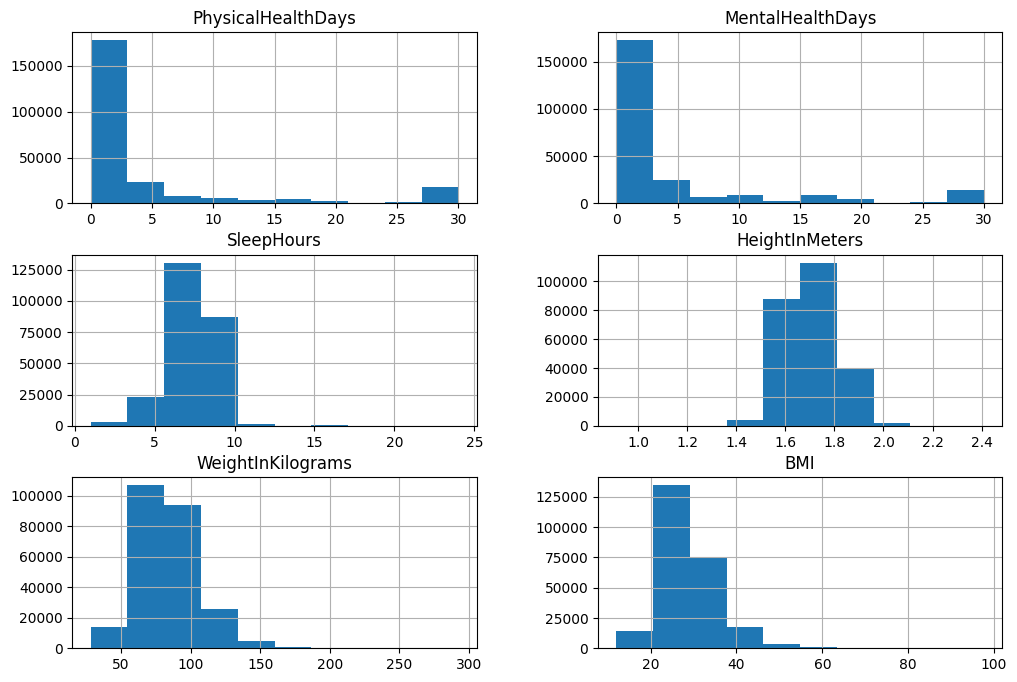

In [62]:
df_clean[df_clean.describe().columns].hist(figsize=(12,8));

The histograms show that none of the numerical features is normally distributed.

Now we will look at the non-numerical features.

In [63]:
#get non-numerical features
non_num_cols = list(set(df_clean.columns) - set(df_clean.describe().columns))
print('Non-numerical features: ',non_num_cols)

Non-numerical features:  ['HadAsthma', 'AgeCategory', 'DifficultyErrands', 'TetanusLast10Tdap', 'BlindOrVisionDifficulty', 'Sex', 'PhysicalActivities', 'DeafOrHardOfHearing', 'SmokerStatus', 'HadAngina', 'GeneralHealth', 'HadCOPD', 'HighRiskLastYear', 'ChestScan', 'AlcoholDrinkers', 'HadStroke', 'DifficultyDressingBathing', 'DifficultyConcentrating', 'PneumoVaxEver', 'HIVTesting', 'CovidPos', 'HadHeartAttack', 'HadSkinCancer', 'State', 'RaceEthnicityCategory', 'FluVaxLast12', 'HadArthritis', 'HadDepressiveDisorder', 'LastCheckupTime', 'HadKidneyDisease', 'DifficultyWalking', 'HadDiabetes', 'ECigaretteUsage', 'RemovedTeeth']


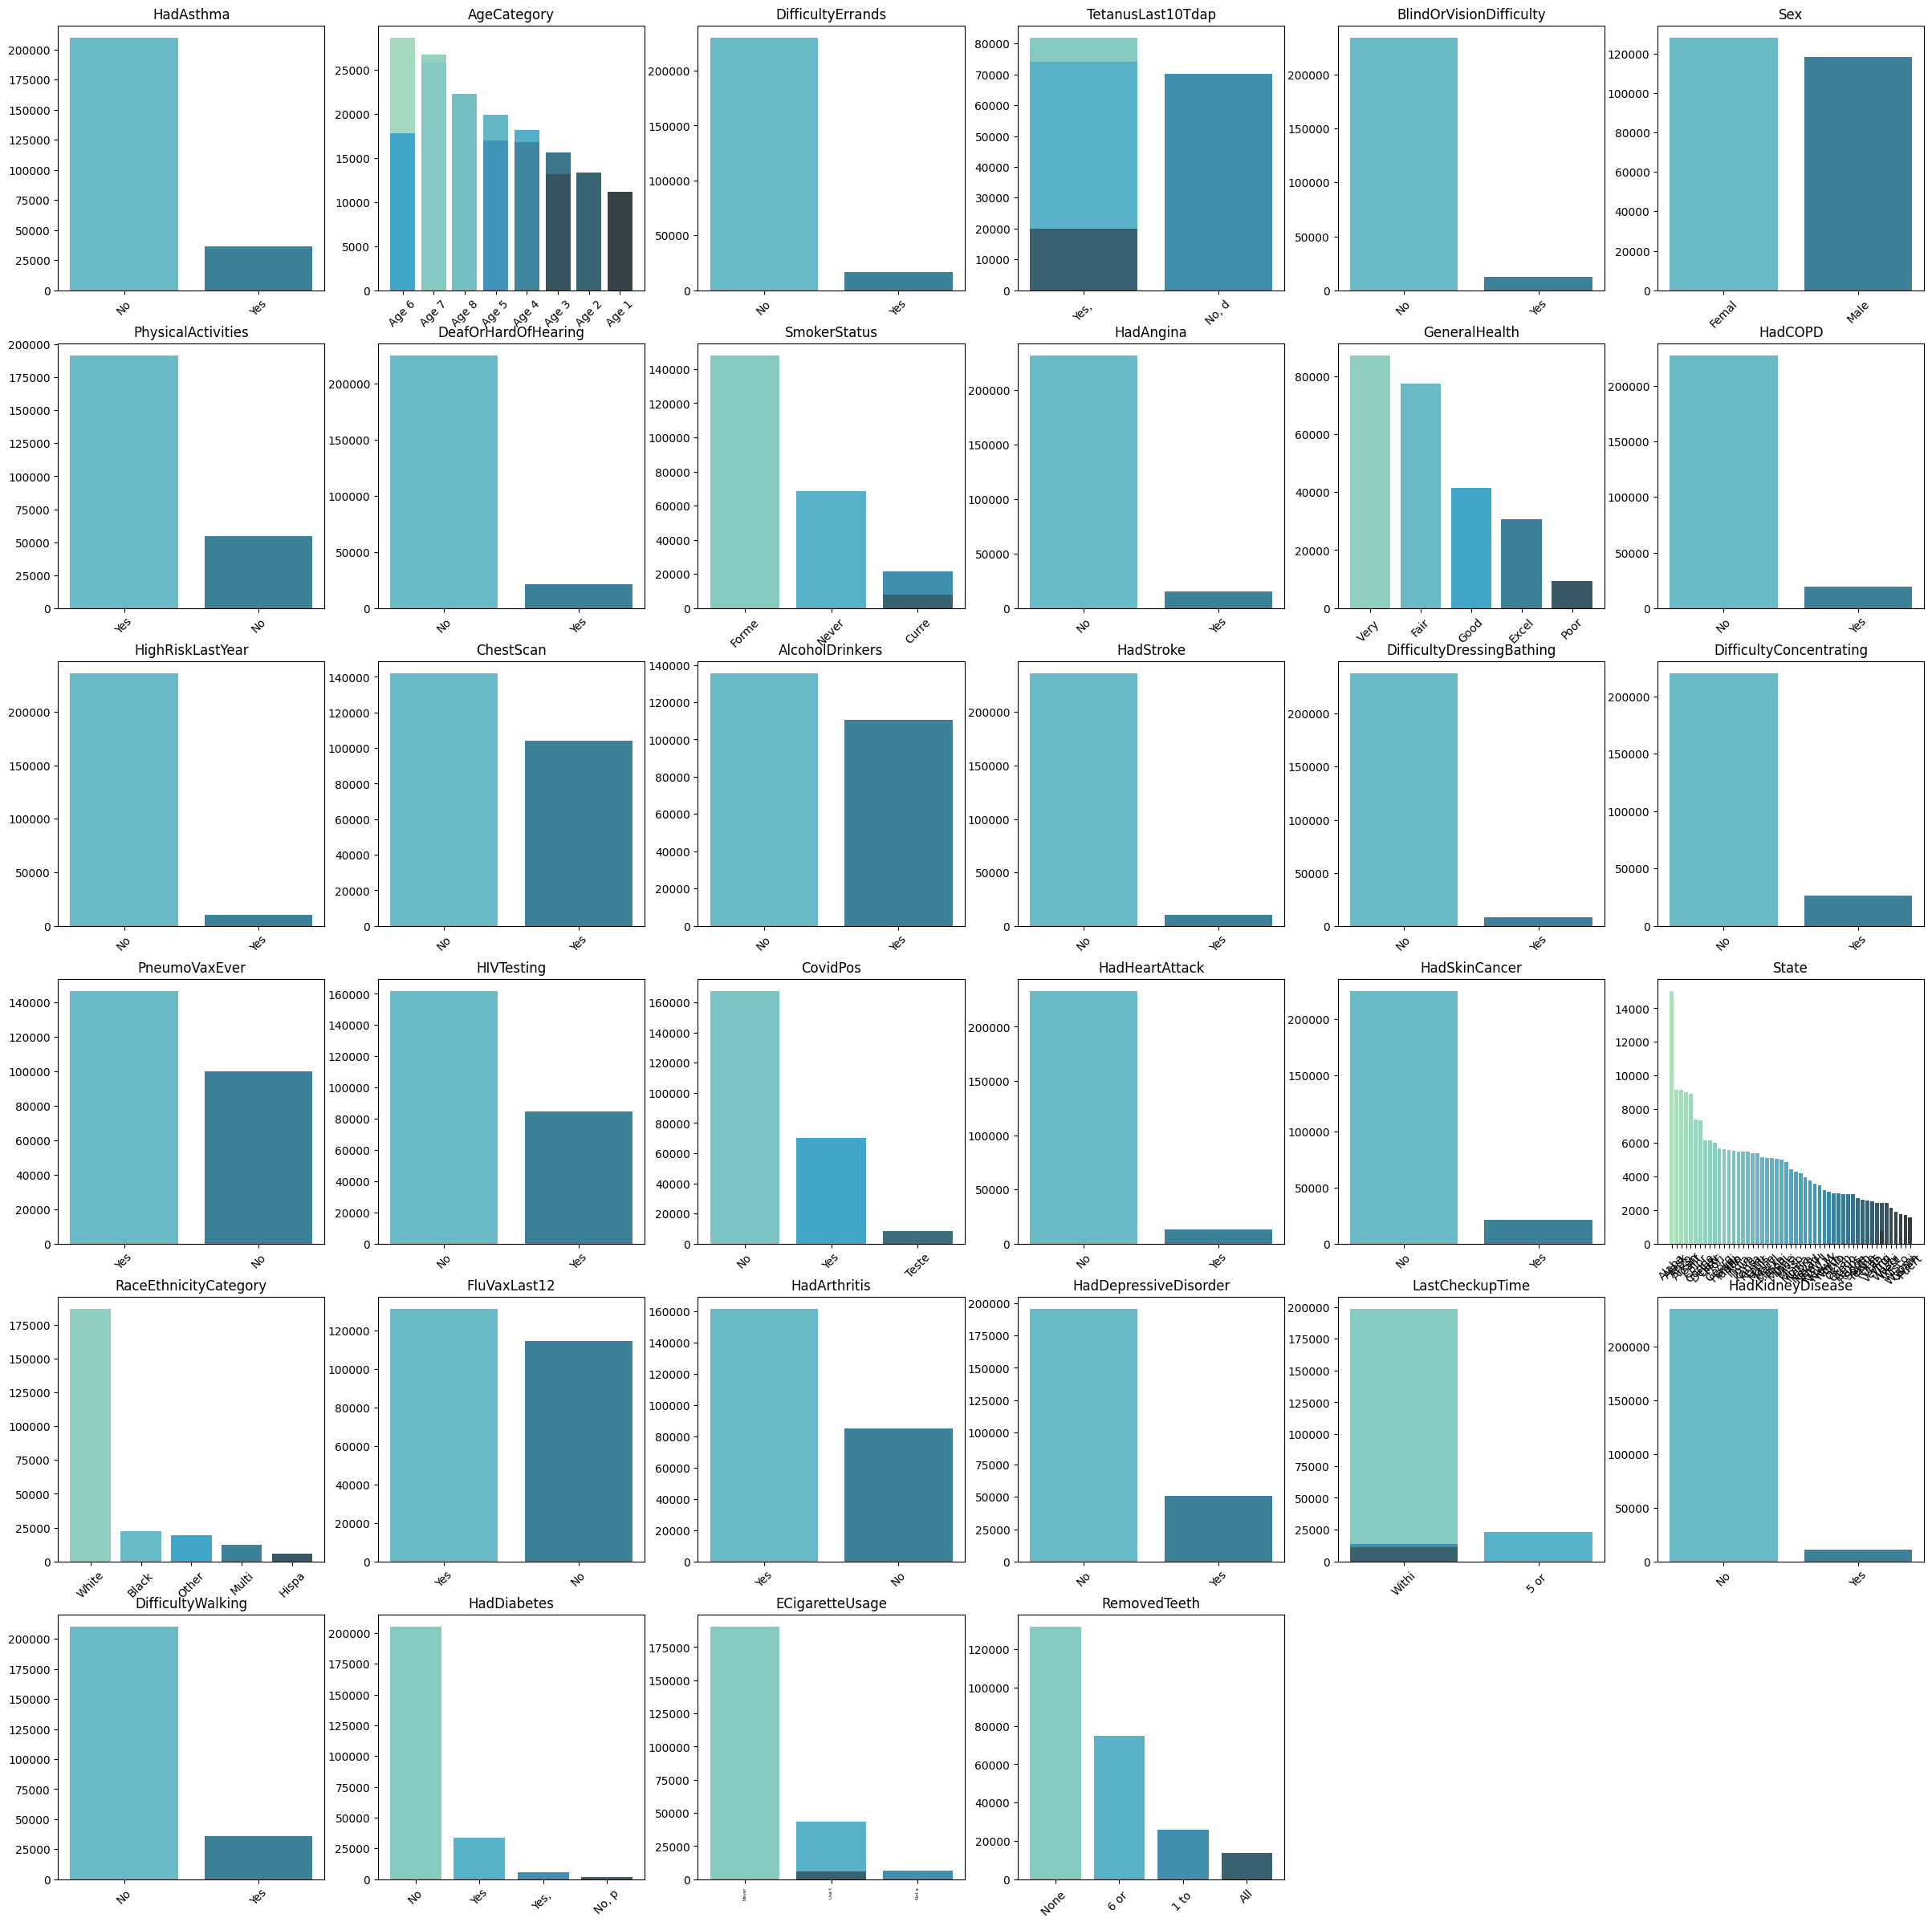

In [64]:
fig, axs = plt.subplots(6, 6,figsize=(30,30))
#Create a bar chart for each of the non-numerical variables.
for i, col in enumerate(non_num_cols):
    #Helper variables to assign the correct axes to each of the 4 plots.
    j=i//6
    k=i%6
    #Setting a color palette for the plots.
    color = sns.color_palette("GnBu_d",n_colors=len(df_clean[col].unique()))
    unique_values = df_clean[col].astype('str').unique()
    # Keep only the first five characters of the x-axis labels
    labels = [value[:5] for value in unique_values]
    axs[j,k].bar(labels, df_clean[col].value_counts(), color=color)
    axs[j,k].set_title(col)
    axs[j,k].tick_params(axis='x', rotation=45)
axs[5,2].tick_params(axis='x', rotation=90,labelsize=4)
axs[5,4].set_visible(False)
axs[5,5].set_visible(False)
plt.show();

Most of the non-numerical variables, including the target incidence "HadHeartAttack" are imbalanced.

# 4 Data pre-possessing

In [65]:
# Preprocessing and model evaluation tools
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder
from sklearn.decomposition import PCA

First, we transform categorical variables into integer type and normalize each variable.

In [66]:
# Extract the Categorical data
cat_df = df_clean.select_dtypes(include=['object'])

# Create the encoder variable
encoder = LabelEncoder()

for i in cat_df:
    # fit the categoral feature to the encoding method
    df_clean[i] = encoder.fit_transform(df_clean[i])

# Check that the value transformed successfully
df_clean['HadDiabetes'].value_counts()

HadDiabetes
0    204834
2     33813
1      5392
3      1983
Name: count, dtype: int64

In [67]:
# Initialize the MinMaxScaler
scaled = MinMaxScaler()

# Fit and transform the data
normalized_data = scaled.fit_transform(df_clean)

# Create a new DataFrame with the normalized data
df_normalized = pd.DataFrame(normalized_data, columns=df_clean.columns)

#check:
df_normalized['HadDiabetes'].value_counts()

HadDiabetes
0.000000    204834
0.666667     33813
0.333333      5392
1.000000      1983
Name: count, dtype: int64

As the dataset involves 52 variables and not all variable can affect the target incidence (for example, the variable "BlindOrVisionDifficulty" should not affect heart disease by common sense), it is necessary to check for linear separability and reduce dimensions when necessary.

We use two methods for dimensionality reduction: check by correlation matrix and Principal Component Analysis (PCA).

## 4.1 Correlation Matrix

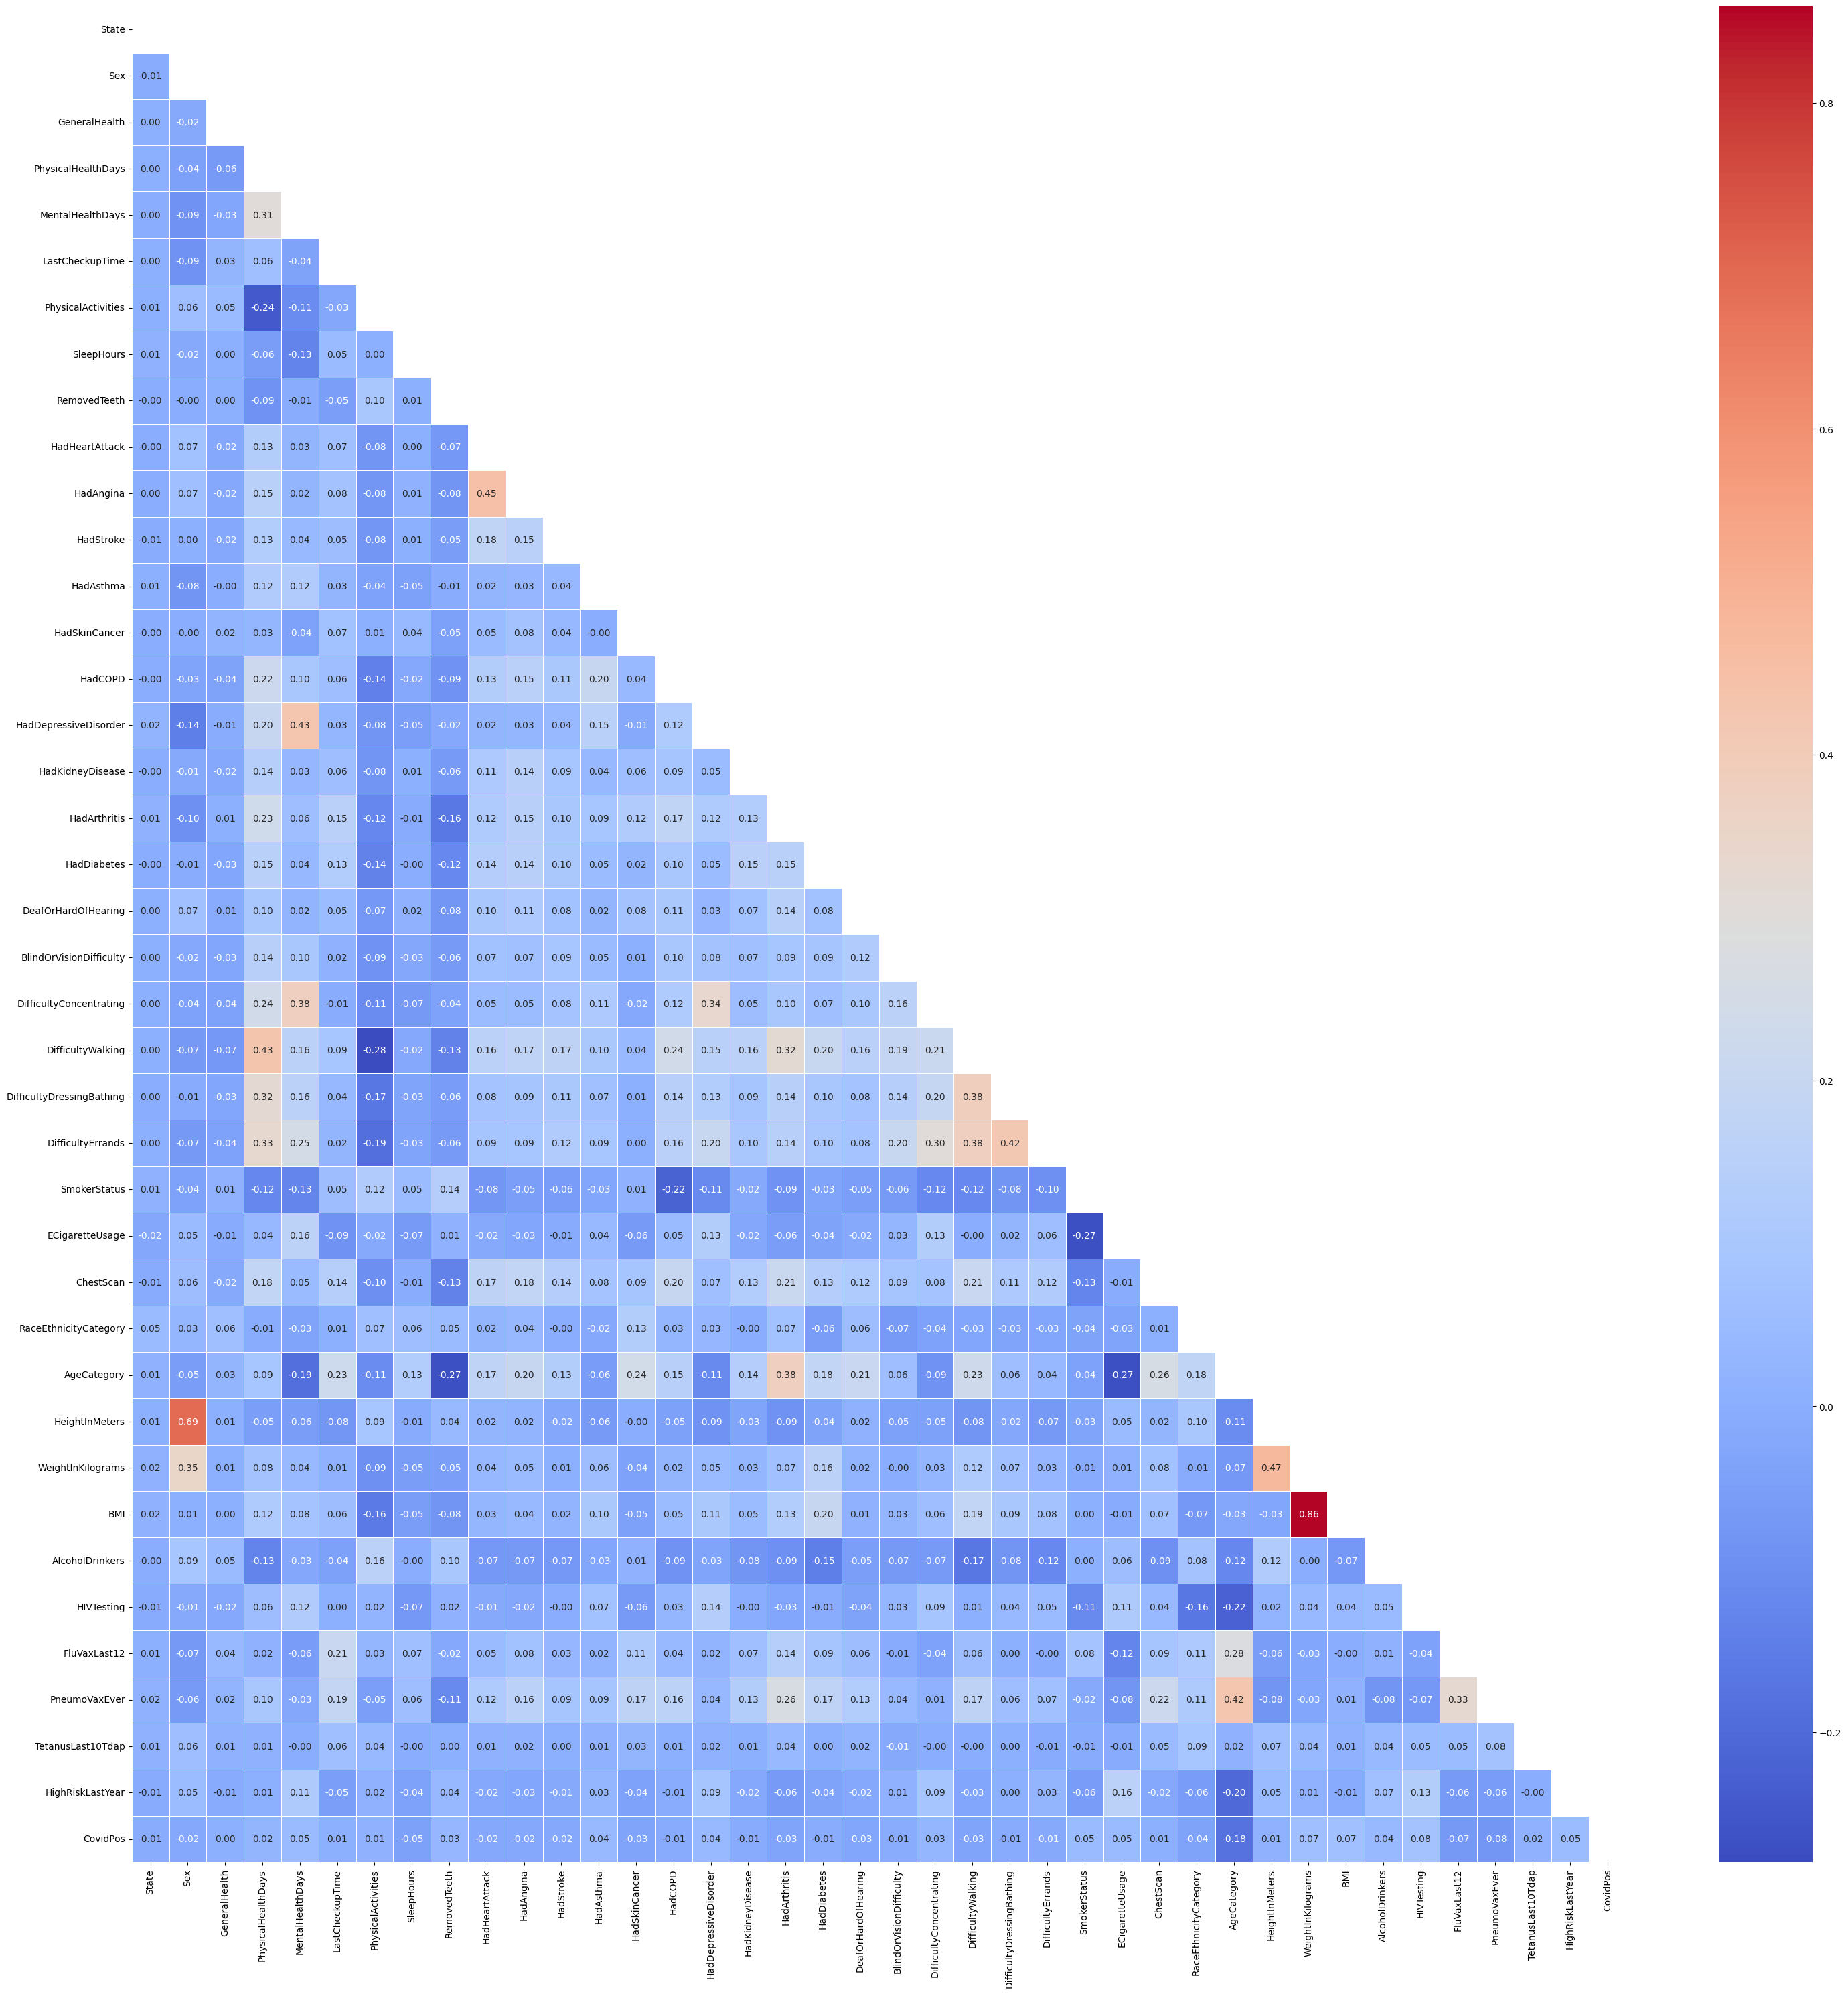

In [68]:
corr_matrix = df_normalized.corr()
plt.figure(figsize = (36,36))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

It seems that most variables do not have high correlation between each other. To reduce model complexity, we decide to drop regressors that have a correlation coefficent (with target variable) of magnitude less than or equal to 0.1, which is the following code:

In [69]:
corr_thres=np.median(abs(corr_matrix['HadHeartAttack']))

In [70]:
df_filtered=df_normalized[corr_matrix.index[abs(corr_matrix['HadHeartAttack'])>corr_thres].tolist()]
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246022 entries, 0 to 246021
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Sex                        246022 non-null  float64
 1   PhysicalHealthDays         246022 non-null  float64
 2   PhysicalActivities         246022 non-null  float64
 3   RemovedTeeth               246022 non-null  float64
 4   HadHeartAttack             246022 non-null  float64
 5   HadAngina                  246022 non-null  float64
 6   HadStroke                  246022 non-null  float64
 7   HadCOPD                    246022 non-null  float64
 8   HadKidneyDisease           246022 non-null  float64
 9   HadArthritis               246022 non-null  float64
 10  HadDiabetes                246022 non-null  float64
 11  DeafOrHardOfHearing        246022 non-null  float64
 12  DifficultyWalking          246022 non-null  float64
 13  DifficultyDressingBathing  24

This leaves 11 features (1 numerical, 10 categorical) left, together with the target variable.

Use X_corr to store the selected features:

In [71]:
X_corr=df_filtered.drop('HadHeartAttack',axis=1)
X_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246022 entries, 0 to 246021
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Sex                        246022 non-null  float64
 1   PhysicalHealthDays         246022 non-null  float64
 2   PhysicalActivities         246022 non-null  float64
 3   RemovedTeeth               246022 non-null  float64
 4   HadAngina                  246022 non-null  float64
 5   HadStroke                  246022 non-null  float64
 6   HadCOPD                    246022 non-null  float64
 7   HadKidneyDisease           246022 non-null  float64
 8   HadArthritis               246022 non-null  float64
 9   HadDiabetes                246022 non-null  float64
 10  DeafOrHardOfHearing        246022 non-null  float64
 11  DifficultyWalking          246022 non-null  float64
 12  DifficultyDressingBathing  246022 non-null  float64
 13  DifficultyErrands          24

## 4.2 PCA

On the other hand, we try to use PCA to get 11 most influential features, and check how similar are they compared with X_corr:



In [72]:
from sklearn.decomposition import PCA

# PCA: dimension reduction in feature space (direction of maximum variance)
X= df_normalized.drop('HadHeartAttack', axis=1)

# Perform PCA to retain 11 components
pca = PCA(n_components=19)
X_pca = pca.fit_transform(X)

# Get the absolute values of the PCA components
absolute_components = np.abs(pca.components_)


# Determine which original features contribute the most to each principal component
X_pca = []
feature_names=X.columns
for i, component in enumerate(absolute_components):
    top_features_indices = np.argsort(component)[::-1][:1]  # Get index of top feature
    X_pca.append(feature_names[top_features_indices[0]])

print("Retained variables from PCA:")
print(X_pca)

Retained variables from PCA:
['PneumoVaxEver', 'FluVaxLast12', 'Sex', 'AlcoholDrinkers', 'AlcoholDrinkers', 'CovidPos', 'RemovedTeeth', 'ChestScan', 'HadArthritis', 'PhysicalActivities', 'PneumoVaxEver', 'GeneralHealth', 'HadAsthma', 'RaceEthnicityCategory', 'DifficultyWalking', 'TetanusLast10Tdap', 'SmokerStatus', 'State', 'DeafOrHardOfHearing']


In [73]:

# PCA: dimension reduction in feature space (direction of maximum variance)
X = df_normalized.drop('HadHeartAttack', axis=1)

# Perform PCA to retain 11 components
pca = PCA(n_components=21)
X_pca = pca.fit_transform(X)

# Get the absolute values of the PCA components
absolute_components = np.abs(pca.components_)

# Determine which original features contribute the most to each principal component
selected_features = set()  # Keep track of selected features to ensure uniqueness
X_pca_unique = []
feature_names = X.columns
for component in absolute_components:
    top_feature_index = np.argmax(component)  # Get index of top feature
    top_feature = feature_names[top_feature_index]
    # Ensure selected feature is unique
    if top_feature not in selected_features:
        X_pca_unique.append(top_feature)
        selected_features.add(top_feature)

print("Retained variables from PCA:")
print(X_pca_unique)


Retained variables from PCA:
['PneumoVaxEver', 'FluVaxLast12', 'Sex', 'AlcoholDrinkers', 'CovidPos', 'RemovedTeeth', 'ChestScan', 'HadArthritis', 'PhysicalActivities', 'GeneralHealth', 'HadAsthma', 'RaceEthnicityCategory', 'DifficultyWalking', 'TetanusLast10Tdap', 'SmokerStatus', 'State', 'DeafOrHardOfHearing', 'DifficultyConcentrating', 'HadSkinCancer']


In [74]:
len(X_pca_unique)

19

In [75]:
X_corr.columns

Index(['Sex', 'PhysicalHealthDays', 'PhysicalActivities', 'RemovedTeeth',
       'HadAngina', 'HadStroke', 'HadCOPD', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ChestScan', 'AgeCategory', 'AlcoholDrinkers', 'PneumoVaxEver'],
      dtype='object')

It turns out that the features selected by PCA are quite different from that by correlation matrix. Nevertheless, we store these 11 features together with target variable into a dataframe named df_filtered_pca, and we would try to examine the performance of these two dataframes in the later section.

In [76]:
data_pca=X_pca_unique.copy()
data_pca.append('HadHeartAttack')
df_filtered_pca=df_normalized[data_pca]
df_filtered_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246022 entries, 0 to 246021
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   PneumoVaxEver            246022 non-null  float64
 1   FluVaxLast12             246022 non-null  float64
 2   Sex                      246022 non-null  float64
 3   AlcoholDrinkers          246022 non-null  float64
 4   CovidPos                 246022 non-null  float64
 5   RemovedTeeth             246022 non-null  float64
 6   ChestScan                246022 non-null  float64
 7   HadArthritis             246022 non-null  float64
 8   PhysicalActivities       246022 non-null  float64
 9   GeneralHealth            246022 non-null  float64
 10  HadAsthma                246022 non-null  float64
 11  RaceEthnicityCategory    246022 non-null  float64
 12  DifficultyWalking        246022 non-null  float64
 13  TetanusLast10Tdap        246022 non-null  float64
 14  Smok

# 5 Basic models

In this section, we would implement the following basic models in sequence:
- Logistic Regression
- Decision Tree
- Support Vector Machine (SVM)
- k-Nearest Neighbors (kNN)
- Perceptron



Import relevant libraries:

In [77]:
# Machine learning models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Machine learning model selection and evaluation
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score, SCORERS
from sklearn.metrics import ConfusionMatrixDisplay

In [37]:
# Install and patch scikit-learn to accelerate code running for KNN and SVM
!pip install scikit-learn-intelex

from sklearnex import patch_sklearn
patch_sklearn("SVC")
patch_sklearn("KNeighborsClassifier")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 MB 5.9 MB/s eta 0:00:00


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Let's first perform train-test split (80%-20%), which would be used across all basic model implementations:

In [78]:
feats= df_filtered.drop('HadHeartAttack', axis=1)
target = df_filtered['HadHeartAttack']
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.2, train_size=0.8, random_state = 90)

The above uses the dataset filtered by correlation matrix, while the following uses the dataset filtered PCA.

In [79]:
feats_alt= df_filtered_pca.drop('HadHeartAttack', axis=1)

target_alt = df_filtered_pca['HadHeartAttack']

X_train_alt, X_test_alt, y_train_alt, y_test_alt = train_test_split(feats_alt, target_alt, test_size=0.2, train_size=0.8, random_state = 92)

## 5.1 Model training

Each model has 2 code blocks below, as the first one for dataset filtered by correlation matrix, and the second one for dataset filtered by PCA.

**Logistic regression:**


In [ ]:
logReg = LogisticRegression()
logReg.fit(X_train, y_train)
y_pred_logReg = logReg.predict(X_test)
tr_accuracy_logReg = logReg.score(X_train, y_train)
ts_accuracy_logReg = logReg.score(X_test, y_test)

In [ ]:
logReg_pca = LogisticRegression()
logReg_pca.fit(X_train_alt, y_train_alt)
y_pred_logReg_pca = logReg_pca.predict(X_test_alt)
tr_accuracy_logReg_pca = logReg_pca.score(X_train_alt, y_train_alt)
ts_accuracy_logReg_pca = logReg_pca.score(X_test_alt, y_test_alt)

**Decision tree:**

In [ ]:
d_t = DecisionTreeClassifier()
d_t.fit(X_train, y_train)
y_pred_d_t = d_t.predict(X_test)
tr_accuracy_d_t = d_t.score(X_train, y_train)
ts_accuracy_d_t = d_t.score(X_test,y_test)

In [ ]:
d_t_pca = DecisionTreeClassifier()
d_t_pca.fit(X_train_alt, y_train_alt)
y_pred_d_t_pca = d_t_pca.predict(X_test_alt)
tr_accuracy_d_t_pca = d_t_pca.score(X_train_alt, y_train_alt)
ts_accuracy_d_t_pca = d_t_pca.score(X_test_alt,y_test_alt)

**Suppport vector machine (SVM):**

In [88]:
svm = SVC(kernel='linear',gamma='auto',probability=True) #soft margin SVM, default C=1.0
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
tr_accuracy_svm = svm.score(X_train, y_train)
ts_accuracy_svm = svm.score(X_test,y_test)
#time complexity for SVM is O(n*d), used Intel® Extension for Scikit-learn to speed up the algorithm
#still requires much longer runtime
#is this method suitable?

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

In [ ]:
svm_pca = SVC(kernel='linear',gamma='auto') #soft margin SVM, default C=1.0
svm_pca.fit(X_train_alt,y_train_alt)
y_pred_svm_pca = svm_pca.predict(X_test_alt)
tr_accuracy_svm_pca = svm_pca.score(X_train_alt, y_train_alt)
ts_accuracy_svm_pca = svm_pca.score(X_test_alt,y_test_alt)

**K nearest neighbors (KNN):**
- number of nearest neighbors (k): k=sqrt(n), where n is the number of data in training set

In [ ]:
k=round(np.sqrt(len(X_train)))
knn = KNeighborsClassifier(k)
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)
tr_accuracy_knn = knn.score(X_train, y_train)
ts_accuracy_knn = knn.score(X_test,y_test)

In [ ]:
k_pca=round(np.sqrt(len(X_train_alt)))
knn_pca = KNeighborsClassifier(k_pca)
knn_pca.fit(X_train_alt,y_train_alt)
y_pred_knn_pca = knn_pca.predict(X_test_alt)
tr_accuracy_knn_pca = knn_pca.score(X_train_alt, y_train_alt)
ts_accuracy_knn_pca = knn_pca.score(X_test_alt,y_test_alt)

**Perceptron:**

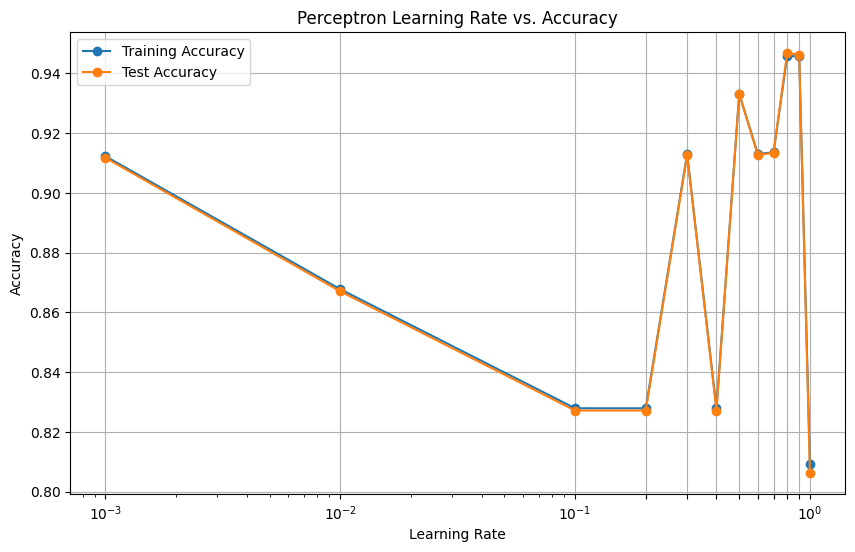

In [47]:
# Define a range of learning rates to experiment with
learning_rates = [0.001, 0.01, 0.1, 0.5, 1.0]

#After initial exxcuation of the code, it seems [0.1,1.0] interval should be further investigated.
extra_learning_rates = [0.2,0.3,0.4,0.6,0.7,0.8,0.9]
learning_rates.extend(extra_learning_rates)
learning_rates=sorted(learning_rates)
train_accuracies = []
test_accuracies = []

# Iterate over each learning rate
for lr in learning_rates:
    perceptron = Perceptron(eta0=lr, max_iter=1000)

    perceptron.fit(X_train, y_train)

    train_predictions = perceptron.predict(X_train)
    test_predictions = perceptron.predict(X_test)

    train_accuracy = accuracy_score(y_train, train_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(learning_rates, test_accuracies, marker='o', label='Test Accuracy')
plt.title('Perceptron Learning Rate vs. Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.xscale('log')  # Use log scale for better visualization
plt.xticks(learning_rates)
plt.legend()
plt.grid(True)
plt.show()

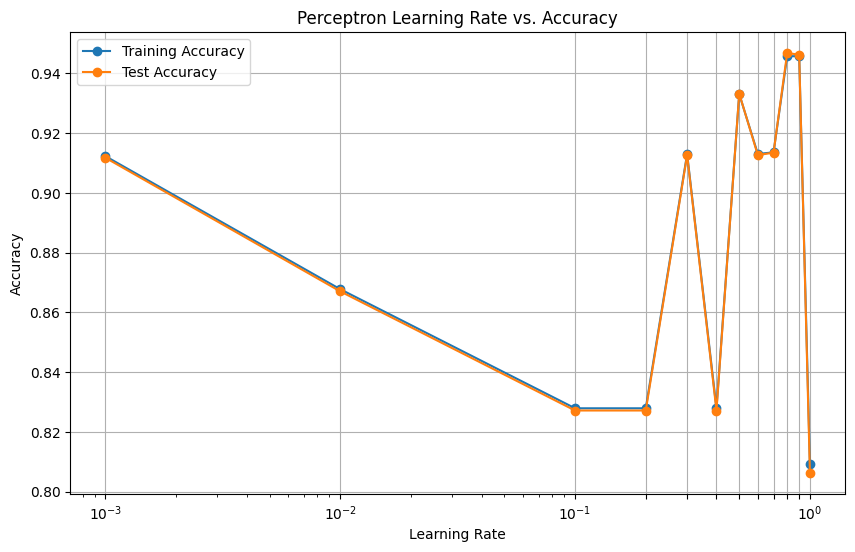

From above figure, it seems we should take learning rate =0.8.

In [48]:
pt = Perceptron(eta0=0.8)
pt.fit(X_train, y_train)
y_pred_pt = pt.predict(X_test)
tr_accuracy_pt = pt.score(X_train, y_train)
ts_accuracy_pt = pt.score(X_test,y_test)

In [49]:
pt_pca = Perceptron(eta0=0.8)
pt_pca.fit(X_train_alt, y_train_alt)
y_pred_pt_pca = pt_pca.predict(X_test_alt)
tr_accuracy_pt_pca = pt_pca.score(X_train_alt, y_train_alt)
ts_accuracy_pt_pca = pt_pca.score(X_test_alt,y_test_alt)

## 5.2 Model Evaluation

Our evaluation metrics will be focusing on recall and f1-score. As the goal of our models will be predicting whether certain patients are in risk of heart disease, it is important for the models to correctly classifies patients who indeed have heart disease. In other words, we aim to maximize true positive, using recall as an indicator.

However, while maximizing recall, we also need to keep the false positive within in a reasonable range as having high false positive will incorrectly classify more people as having heart disease. Therefore, f1-score will be a good indicator as it balances precision and recall by taking their harmonic mean.

In short, we will be looking at the model with the highest recall, while ensuring a relatively high f1-score and testing accuracy.

### 5.2.1 Accuracy

In [ ]:
data = [["Log Reg", tr_accuracy_logReg,ts_accuracy_logReg,tr_accuracy_logReg_pca,ts_accuracy_logReg_pca],
        ["Decision Tree", tr_accuracy_d_t,ts_accuracy_d_t,tr_accuracy_d_t_pca,ts_accuracy_d_t_pca],
        ["SVM",tr_accuracy_svm,ts_accuracy_svm,tr_accuracy_svm_pca,ts_accuracy_svm_pca],
        ["KNN", tr_accuracy_knn,ts_accuracy_knn,tr_accuracy_knn_pca,ts_accuracy_knn_pca],
        ["Perceptron",tr_accuracy_pt,ts_accuracy_pt,tr_accuracy_pt_pca,ts_accuracy_pt_pca]]

col_names = ["Model", "Corr Training accuracy", "Corr Testing Accuracy","PCA Training accuracy", "PCA Testing Accuracy"]
print(tabulate(data, headers=col_names))

Model            Corr Training accuracy    Corr Testing Accuracy    PCA Training accuracy    PCA Testing Accuracy
-------------  ------------------------  -----------------------  -----------------------  ----------------------
Log Reg                        0.94784                  0.9484                   0.945193                0.945676
Decision Tree                  0.988167                 0.924642                 0.997007                0.897226
SVM                            0.945254                 0.94594                  0.945254                0.94594
KNN                            0.945675                 0.946367                 0.945254                0.94594
Perceptron                     0.910988                 0.909745                 0.944857                0.945656


| Model | Corr Training Accuracy |Corr Testing Accuracy |PCA Training Accuracy|PCA Testing Accuracy|
| --- | --- | --- |---|---|
| Log Reg |  0.94784 | 0.9484|0.945193|0.945676|
|Decision Tree  | 0.988167 |0.924601|0.997007|0.896962|
|SVM|0.945254 | 0.94594|0.945254|0.94594|
|KNN  | 0.945681 | 0.946408|0.945254|0.94594|
|Perceptron|0.910988| 0.909745|0.944857|0.945656|

Logistic Regression, SVM, and kNN have similar training and test accuracy between 94% and 95%, decision tree model overfits and has a higher training accuracy and lower testing accuracy. Compared with the rest, perceptron has both lower training and testing accuracy when using correlation matrix and similar accuracy when using PCA.

There isn't much difference between models or data pre-possessing methods simply by observing accuracy.

### 5.2.2 Classification Report

In [50]:
print("Classification Report for logistic regression: \n", classification_report(y_test, y_pred_logReg))
print("Classification Report for decision tree: \n", classification_report(y_test, y_pred_d_t))
print("Classification Report for SVM: \n", classification_report(y_test, y_pred_svm))
print("Classification Report for KNN: \n", classification_report(y_test, y_pred_knn))
print("Classification Report for perceptron: \n", classification_report(y_test, y_pred_pt))

NameError: name 'y_pred_logReg' is not defined

**Result for corr_threshold=median**

Classification Report for logistic regression:
```markdown
               precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     46545
         1.0       0.55      0.25      0.34      2660

    accuracy                           0.95     49205
   macro avg       0.75      0.62      0.66     49205
weighted avg       0.94      0.95      0.94     49205
```

Classification Report for decision tree:
```markdown
               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96     46545
         1.0       0.29      0.28      0.28      2660

    accuracy                           0.92     49205
   macro avg       0.63      0.62      0.62     49205
weighted avg       0.92      0.92      0.92     49205
```
Classification Report for SVM:
```markdown
               precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     46545
         1.0       0.00      0.00      0.00      2660

    accuracy                           0.95     49205
   macro avg       0.47      0.50      0.49     49205
weighted avg       0.89      0.95      0.92     49205
```
Classification Report for knn:
```markdown
               precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     46545
         1.0       0.76      0.01      0.02      2660

    accuracy                           0.95     49205
   macro avg       0.85      0.51      0.50     49205
weighted avg       0.94      0.95      0.92     49205
```
Classification Report for perceptron:
```markdown
               precision    recall  f1-score   support

         0.0       0.97      0.93      0.95     46545
         1.0       0.31      0.53      0.39      2660

    accuracy                           0.91     49205
   macro avg       0.64      0.73      0.67     49205
weighted avg       0.94      0.91      0.92     49205
```

In [ ]:
print("Classification Report for logistic regression: \n", classification_report(y_test_alt, y_pred_logReg_pca))
print("Classification Report for decision tree: \n", classification_report(y_test_alt, y_pred_d_t_pca))
print("Classification Report for SVM: \n", classification_report(y_test_alt, y_pred_svm_pca))
print("Classification Report for knn: \n", classification_report(y_test_alt, y_pred_knn_pca))
print("Classification Report for perceptron: \n", classification_report(y_test_alt, y_pred_pt_pca))

Classification Report for log reg: 
               precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     46545
         1.0       0.16      0.00      0.00      2660

    accuracy                           0.95     49205
   macro avg       0.55      0.50      0.49     49205
weighted avg       0.90      0.95      0.92     49205

Classification Report for decision tree: 
               precision    recall  f1-score   support

         0.0       0.95      0.94      0.95     46545
         1.0       0.13      0.17      0.15      2660

    accuracy                           0.90     49205
   macro avg       0.54      0.55      0.55     49205
weighted avg       0.91      0.90      0.90     49205

Classification Report for SVM: 
               precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     46545
         1.0       0.00      0.00      0.00      2660

    accuracy                           0.95     49205
   macro avg   

**Result of using PCA**

Classification Report for logistic regression:
```markdown
               precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     46545
         1.0       0.16      0.00      0.00      2660

    accuracy                           0.95     49205
   macro avg       0.55      0.50      0.49     49205
weighted avg       0.90      0.95      0.92     49205
```
Classification Report for decision tree:
```markdown
               precision    recall  f1-score   support

         0.0       0.95      0.94      0.95     46545
         1.0       0.14      0.17      0.15      2660

    accuracy                           0.90     49205
   macro avg       0.54      0.55      0.55     49205
weighted avg       0.91      0.90      0.90     49205
```
Classification Report for SVM:
```markdown
               precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     46545
         1.0       0.00      0.00      0.00      2660

    accuracy                           0.95     49205
   macro avg       0.47      0.50      0.49     49205
weighted avg       0.89      0.95      0.92     49205
```
Classification Report for knn:
```markdown
               precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     46545
         1.0       0.00      0.00      0.00      2660

    accuracy                           0.95     49205
   macro avg       0.47      0.50      0.49     49205
weighted avg       0.89      0.95      0.92     49205
```
Classification Report for perceptron:
```markdown
               precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     46545
         1.0       0.27      0.00      0.01      2660

    accuracy                           0.95     49205
   macro avg       0.61      0.50      0.49     49205
weighted avg       0.91      0.95      0.92     49205
```

Although all models achieved high testing accuracy, the models have low recall or f1-score. Compared with using correlation matrix, models trained by PCA possessed data have much lower recall and f1-score.

### 5.2.3 Confusion Matrix

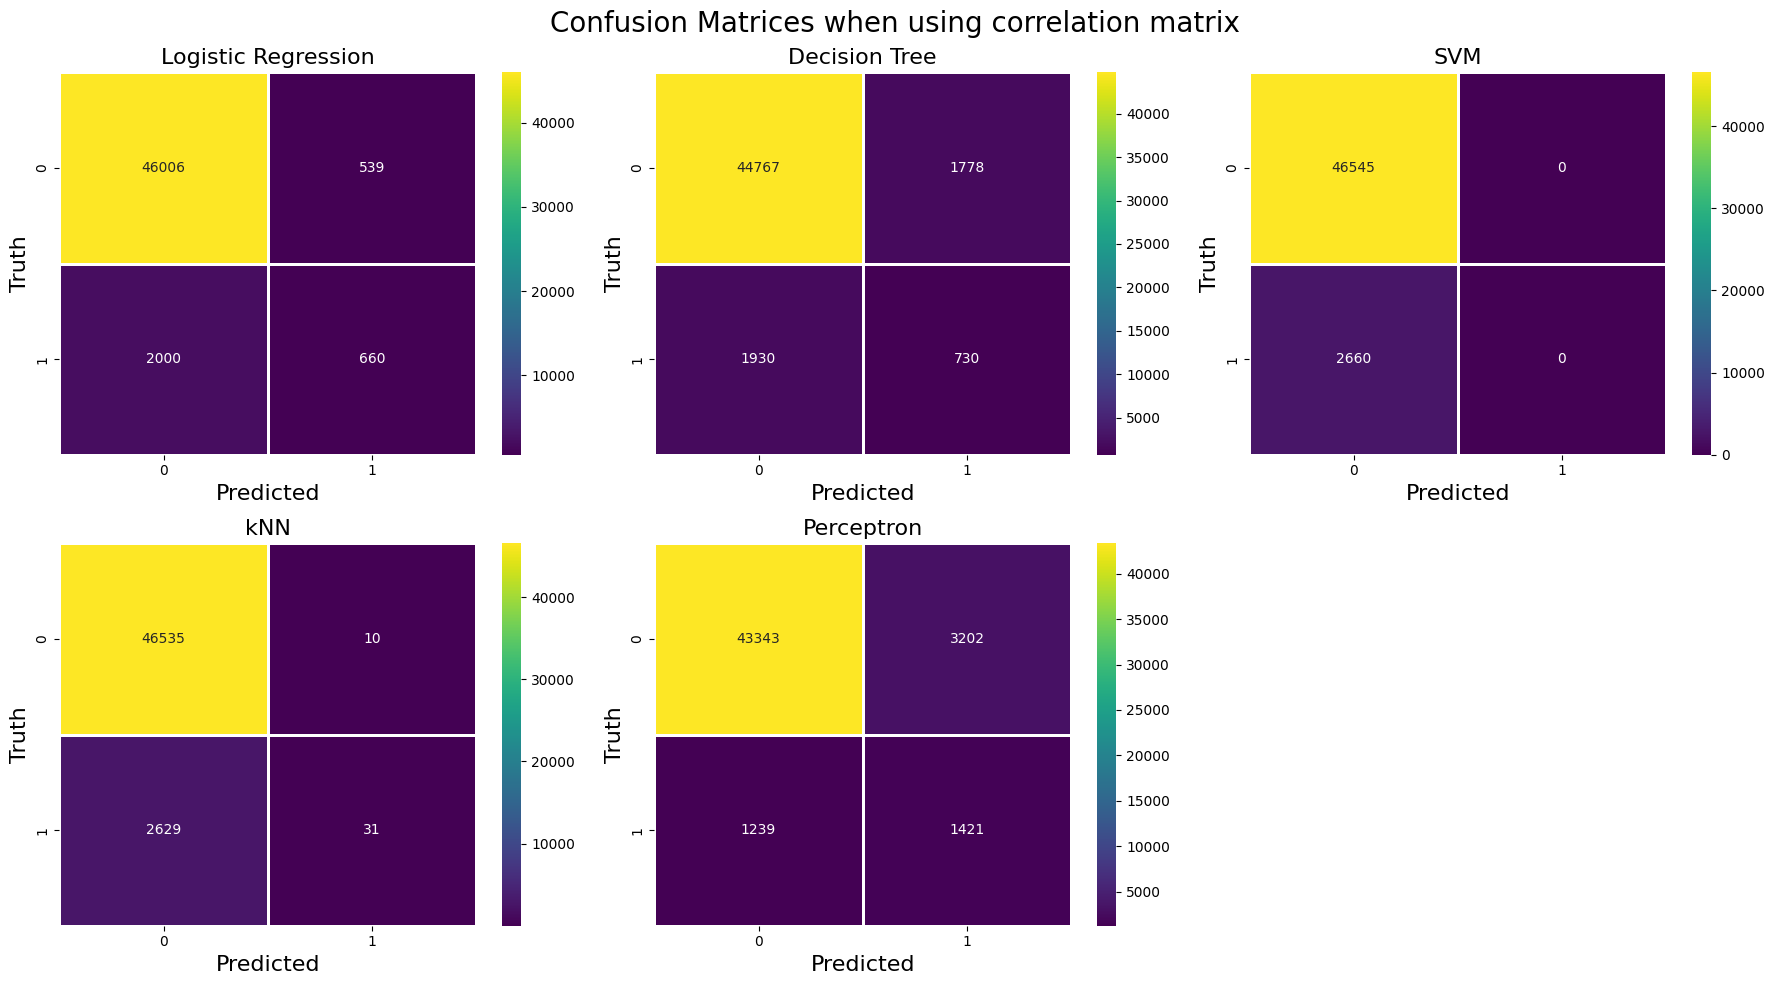

In [ ]:
cm_logReg = confusion_matrix(y_test,y_pred_logReg)
cm_dt = confusion_matrix(y_test,y_pred_d_t)
cm_svm = confusion_matrix(y_test,y_pred_svm)
cm_knn = confusion_matrix(y_test,y_pred_knn)
cm_pt = confusion_matrix(y_test,y_pred_pt)

fig, axs = plt.subplots(2,3, figsize=(18,10))

plot_confusion_matrix(axs[0,0], cm_logReg, title='Logistic Regression')
plot_confusion_matrix(axs[0,1], cm_dt, title='Decision Tree')
plot_confusion_matrix(axs[0,2], cm_svm, title='SVM')
plot_confusion_matrix(axs[1,0], cm_knn, title='kNN')
plot_confusion_matrix(axs[1,1], cm_pt, title='Perceptron')

axs[1][2].set_visible(False)

fig.suptitle('Confusion Matrices when using correlation matrix', fontsize=20)
plt.tight_layout()
plt.show()

Sample confusion matrices:
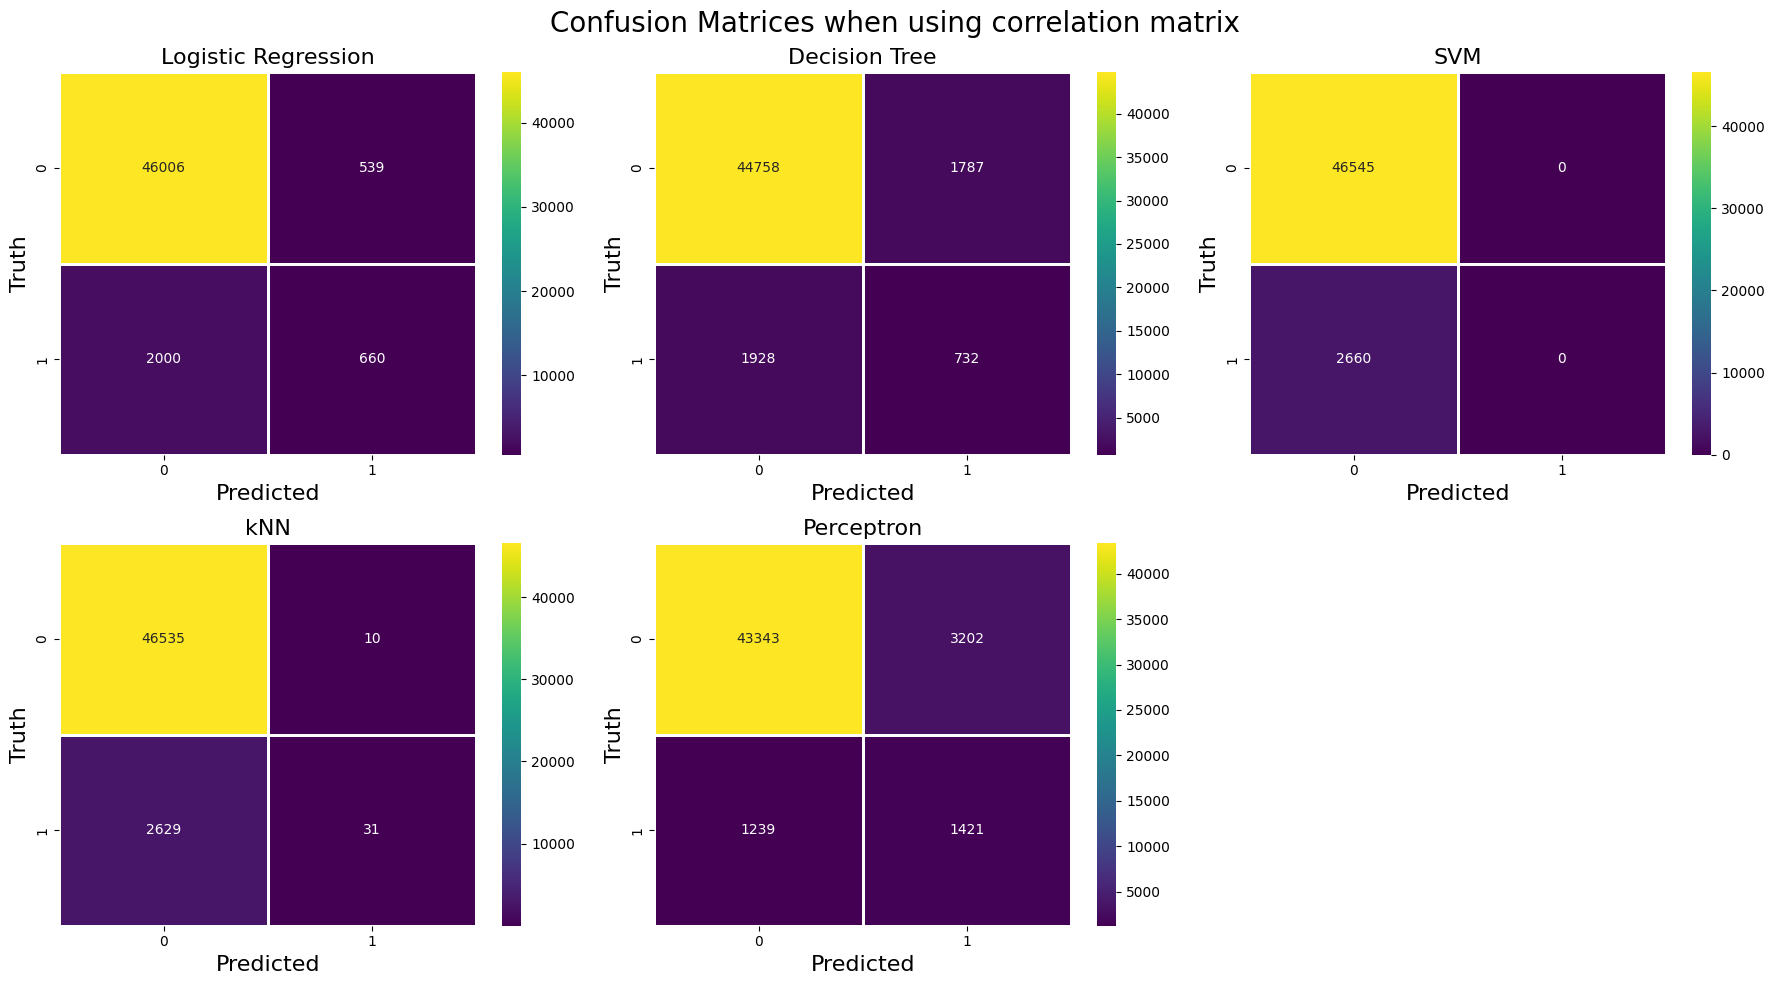

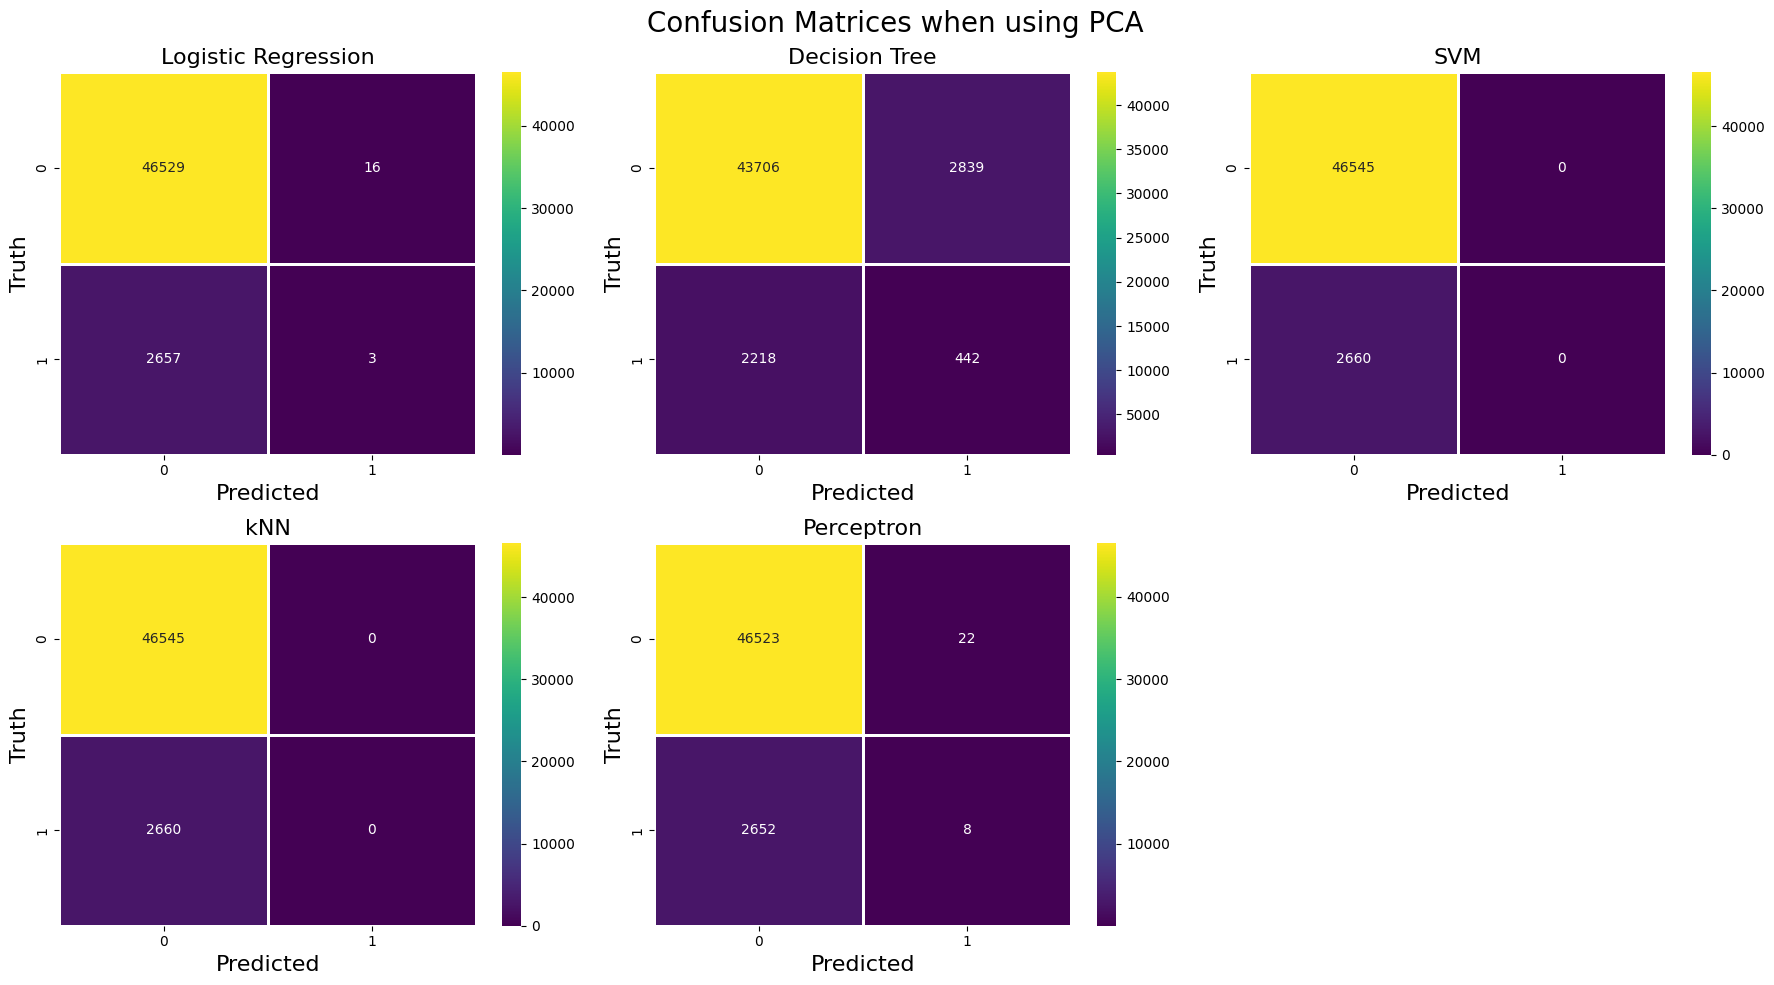

In [ ]:
cm_logReg_pca = confusion_matrix(y_test_alt,y_pred_logReg_pca)
cm_dt_pca = confusion_matrix(y_test_alt,y_pred_d_t_pca)
cm_svm_pca = confusion_matrix(y_test_alt,y_pred_svm_pca)
cm_knn_pca = confusion_matrix(y_test_alt,y_pred_knn_pca)
cm_pt_pca = confusion_matrix(y_test_alt,y_pred_pt_pca)

fig, axs = plt.subplots(2,3, figsize=(18,10))

plot_confusion_matrix(axs[0,0], cm_logReg_pca, title='Logistic Regression')
plot_confusion_matrix(axs[0,1], cm_dt_pca, title='Decision Tree')
plot_confusion_matrix(axs[0,2], cm_svm_pca, title='SVM')
plot_confusion_matrix(axs[1,0], cm_knn_pca, title='kNN')
plot_confusion_matrix(axs[1,1], cm_pt_pca, title='Perceptron')

axs[1][2].set_visible(False)

fig.suptitle('Confusion Matrices when using PCA', fontsize=20)
plt.tight_layout()
plt.show()

Sample confusion matrices:
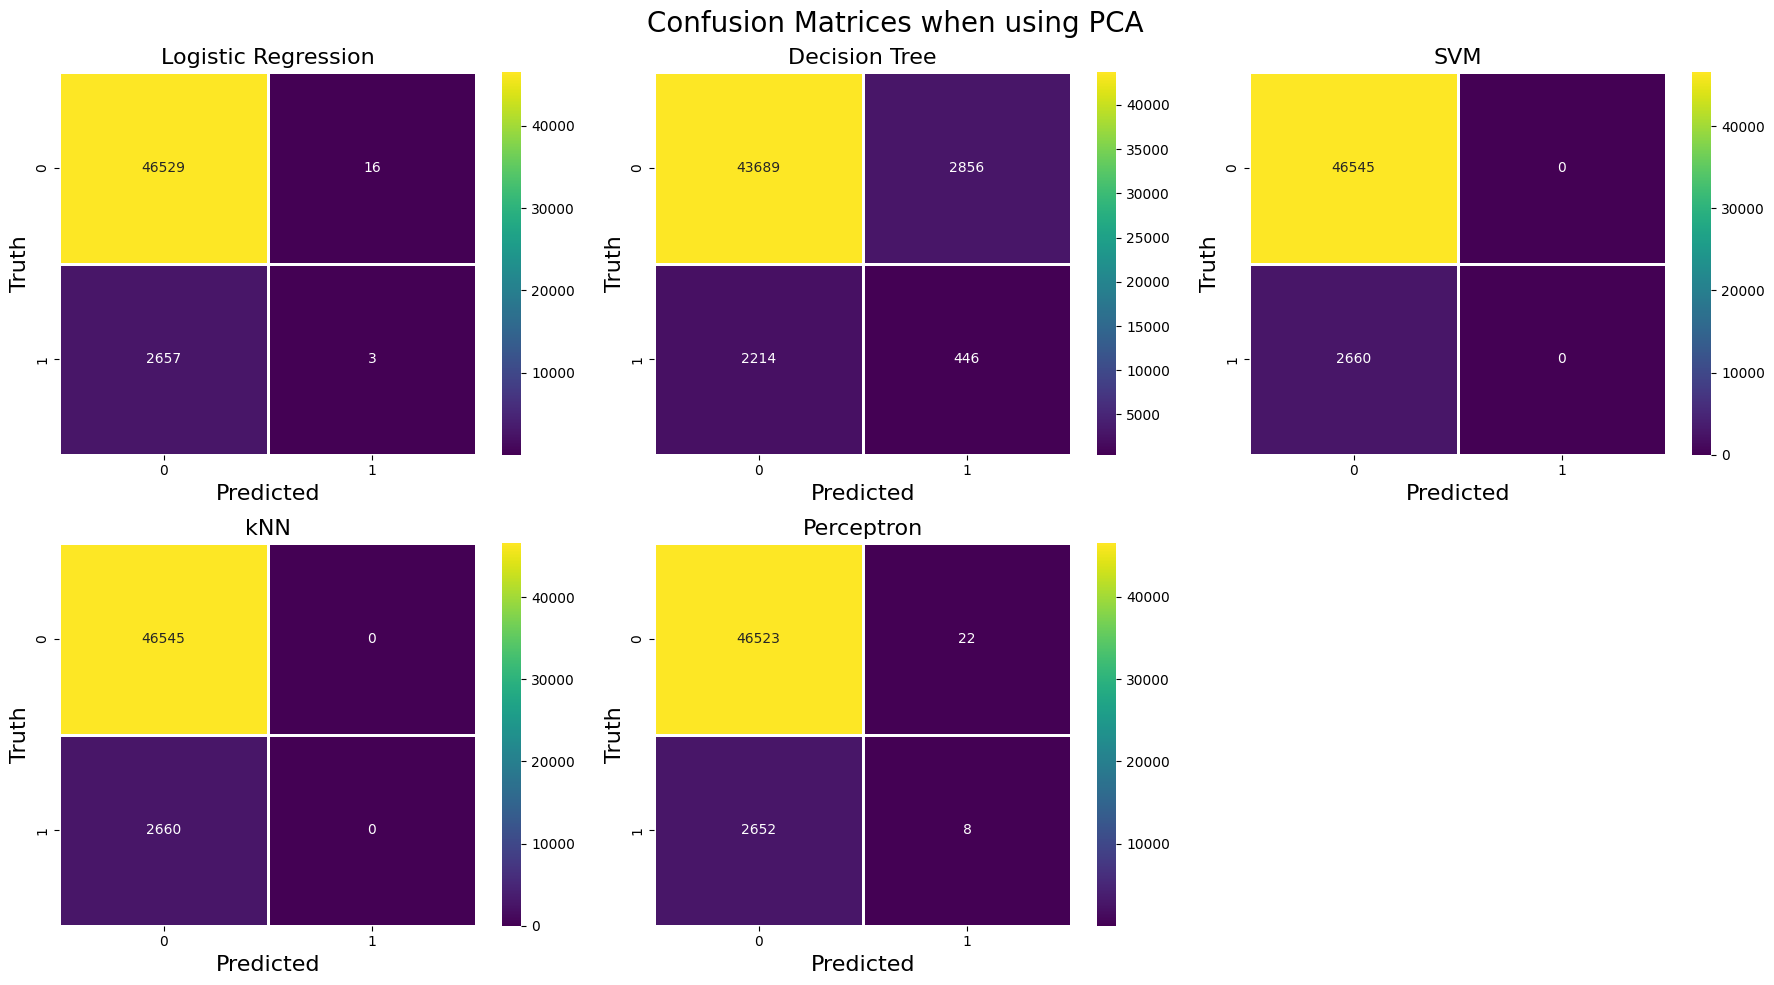

The confusion matrices agree with the result of classfification report. Logistic Regression, Decision Tree, SVM, and kNN have high false positive. While Perceptron has a lower false positive, it suffered from high false negative.

Models trained by PCA possessed data have much larger false positive and false negative.

### 5.2.4 ROC Curve

The Perceptron algorithm does not model the probability distribution of the data, therefore, we cannot plot the ROC curve of the Perceptron model.

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(12,8))

plot_roc_auc(axs[0,0], logReg, X_test, y_test, label='Logistic Regression')
plot_roc_auc(axs[0,1], d_t, X_test, y_test, label='Decison Tree')
plot_roc_auc(axs[1,0], svm, X_test, y_test, label='SVM')
plot_roc_auc(axs[1,1], knn, X_test, y_test, label='KNN')

fig.suptitle('ROC Curve when using correlation matrix', fontsize=20)
plt.tight_layout()
plt.show()

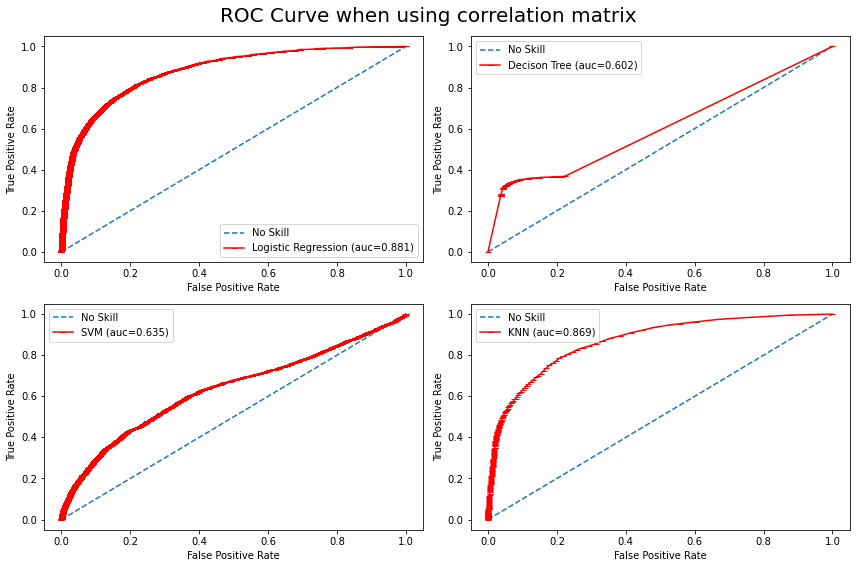

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(12,8))

plot_roc_auc(axs[0,0], logReg_pca, X_test_alt, y_test_alt, label='Logistic Regression')
plot_roc_auc(axs[0,1], d_t_pca, X_test_alt, y_test_alt, label='Decison Tree')
plot_roc_auc(axs[1,0], svm_pca, X_test_alt, y_test_alt, label='SVM')
plot_roc_auc(axs[1,1], knn_pca, X_test_alt, y_test_alt, label='KNN')

fig.suptitle('ROC Curve when using PCA', fontsize=20)
plt.tight_layout()
plt.show()

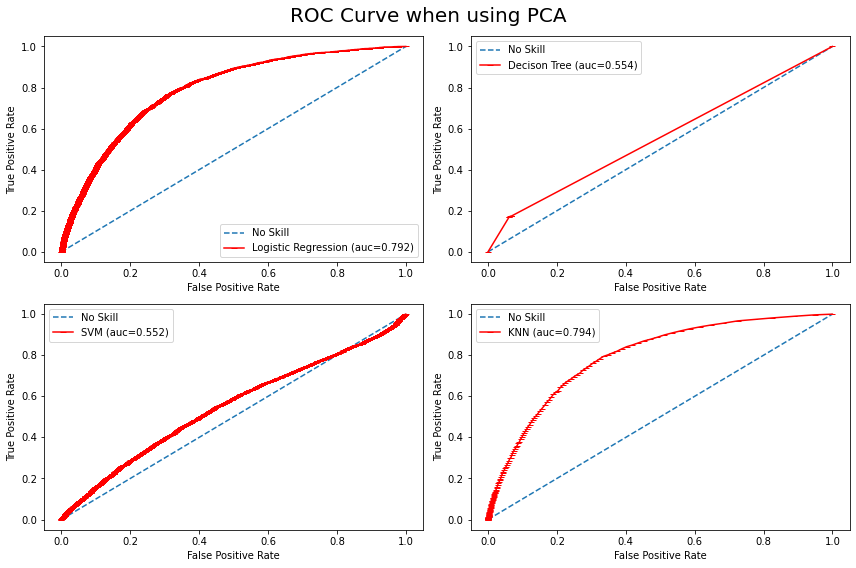

## 5.3 Evaluation Result
Models with features selected through filtering out lower correlated ones perform better than models with features selected through PCA.
For the rest of the project, we will proceed with the dataset selected using correlation coefficient.

# 6 Handling imbalanced dataset
The imbalanced nature of the dataset leads to the problem of the models overfitting to the majority group, resulting in low recall and low f1-score, we consider two methods to handle class imbalance: resampling and class weights.

In [ ]:
# Handling imbalanced datasets
from sklearn.utils import resample
from imblearn.over_sampling import SMOTENC

## 6.1 Resampling
For resampling, we only consider oversampling as undersampling would cause a significant loss of training data.

Two oversampling techniques are used: random oversampling and SMOTE-NC.

### 6.1.1 Random Oversampling

In [ ]:
pd.DataFrame(y_train,columns=['HadHeartAttack']).HadHeartAttack.value_counts(normalize=True)

HadHeartAttack
0.0    0.945254
1.0    0.054746
Name: proportion, dtype: float64

The target incidence is highly imbalanced, we perform a random oversampling on the training set.

In [ ]:
# Concatenate the training features and target variable
train_df = pd.concat([pd.DataFrame(X_train), pd.Series(y_train)], axis=1)
train_df.columns = list(range(train_df.shape[1]))

# Separate the majority and minority classes
majority_class = train_df[train_df[train_df.columns[-1]] == 0]
minority_class = train_df[train_df[train_df.columns[-1]] == 1]

# Upsample the minority class to match the number of majority class samples
minority_upsampled = resample(minority_class,
                               replace=True,  # Sample with replacement
                               n_samples=len(majority_class),  # Match the number of majority class samples
                               random_state=92)  # Set random state for reproducibility

# Concatenate the upsampled minority class with the majority class
train_df_upsampled = pd.concat([majority_class, minority_upsampled])

# Shuffle the dataset to mix minority and majority class samples
train_df_upsampled = train_df_upsampled.sample(frac=1, random_state=92)

# Separate the features and target variable
X_train_upsampled = train_df_upsampled.iloc[:, :-1].values
y_train_upsampled = train_df_upsampled.iloc[:, -1].values

In [ ]:
pd.DataFrame(y_train_upsampled,columns=['HadHeartAttack']).HadHeartAttack.value_counts(normalize=True)

HadHeartAttack
1.0    0.5
0.0    0.5
Name: proportion, dtype: float64

After applying random oversampling on the training dataset, the new target incidence becomes balanced.

In [ ]:
#random oversampling so that the target incidence has 1 to 1 distribution
results1 = baseline_models(data=[X_train_upsampled, X_test, y_train_upsampled, y_test],k=round(np.sqrt(len(X_train_upsampled))))
results1.sort_values('f1',ascending=False)

,f1,roc_auc,accuracy,precision,recall
Perceptron,0.401496,0.668839,0.941469,0.448885,0.363158
SVM,0.356301,0.790176,0.861213,0.237766,0.710526
LogisticRegression,0.326738,0.794223,0.832659,0.208777,0.751128
KNN,0.314607,0.782376,0.827680,0.200391,0.731579
DecisionTree,0.235363,0.614733,0.894096,0.193020,0.301504


| | f1|	roc_auc|	accuracy|	precision|	recall|
|---|---|---|---|---|---|
|SVM|	0.344328|	0.761948|	0.867493	|0.235036|	0.643609
|LogisticRegression|	0.326043|	0.787967|	0.835911|	0.209549	|0.734211
|KNN|	0.311944|	0.785786|	0.822396	|0.197291|	0.744737
|DecisionTree|	0.269628|	0.696169|	0.844975|	0.180884	|0.529323

In [ ]:
#random oversampling so that the target incidence has 0.627-0.375 distribution
results2 = baseline_models(data=[X_train_upsampled, X_test, y_train_upsampled, y_test],k=round(np.sqrt(len(X_train_upsampled))))
results2.sort_values('f1',ascending=False)

|  | f1 | roc_auc | accuracy | precision | recall |
| --- | --- | --- | --- | --- | --- |
| SVM|	0.427184|	0.753874	|0.917265|	0.341354|	0.570677
|LogisticRegression|	0.406277	|0.770216	|0.901575	|0.301437	|0.622932
|KNN|	0.400484|	0.768513	|0.899360	|0.295357|	0.621805
|DecisionTree|	0.325642|	0.695291	|0.894279|	0.248516|	0.472180

Comparing to the result of the original training dataset:

In [ ]:
results3 = baseline_models(data=[X_train, X_test, y_train, y_test])
results3.sort_values('f1',ascending=False)

|  | f1 | roc_auc | accuracy | precision | recall |
| --- | --- | --- | --- | --- | --- |
| LogisticRegression | 0.300584 | 0.60059 | 0.946469 | 0.511754 | 0.212782 |
| KNN | 0.265221 | 0.58472 | 0.946286 | 0.509072 | 0.179323 |
| DecisionTree | 0.261301 | 0.58682 | 0.942546 | 0.428449 | 0.187970 |
| SVM | 0.000000 | 0.50000 | 0.945940 | 0.000000 | 0.000000 |

Random oversampling may lead to overfitting, where the model becomes too specific to the training data and may not generalize well to new data.

The reason is that random oversampling does not add new information to the dataset. The new samples are generated by duplicating existing data. Hence, they do not provide further details about the minority class or classes, and instead, it might just increase their noise.

### 6.1.2 SMOTE-NC

In [ ]:
cat_col_index = list(range(1,11))
sm = SMOTENC(categorical_features=cat_col_index, random_state=123, sampling_strategy=1)
X_trainres, y_trainres = sm.fit_resample(X_train, y_train)

In [ ]:
pd.DataFrame(y_trainres,columns=['HadHeartAttack']).HadHeartAttack.value_counts(normalize=True)

After applying SMOTE-NC on the training dataset, the new target incidence becomes balanced.

In [ ]:
#smote nc with sampling strategy 1 (50%-50% after smote nc)
results1 = baseline_models(data=[X_trainres, X_test, y_trainres, y_test],k=round(np.sqrt(len(X_trainres))))
results1.sort_values('f1',ascending=False)

| | f1|	roc_auc|	accuracy|	precision|	recall|
|---|---|---|---|---|---|
|SVM|	0.364101|	0.777389	|0.873570|	0.250035	|0.669549|
|KNN|	0.320377|	0.783584	|0.832984|	0.205365|	0.728195|
|LogisticRegression|	0.317083|	0.787080|	0.827192|	0.201614|	0.742105|
|DecisionTree|	0.283859|	0.681863|	0.872228|	0.203628	|0.468421|

In [ ]:
#smote nc with sampling strategy 0.6 (0.625-0.375 after smote nc)
results1 = baseline_models(data=[X_trainres, X_test, y_trainres, y_test],k=round(np.sqrt(len(X_trainres))))
results1.sort_values('f1',ascending=False)

| | f1|	roc_auc|	accuracy|	precision|	recall|
|---|---|---|---|---|---|
|SVM	|0.430135|	0.756629|	0.917447	|0.343107	|0.576316
|LogisticRegression	|0.401695|	0.769507	|0.899563	|0.296250|	0.623684
|KNN|	0.387845	|0.768201	|0.892734|	0.280443	|0.628571
|DecisionTree|	0.331507|	0.674395	|0.910741	|0.278517|	0.409398


Comparing to the result of the original training dataset:

In [ ]:
results3 = baseline_models(data=[X_train, X_test, y_train, y_test])
results3.sort_values('f1',ascending=False)

|  | f1 | roc_auc | accuracy | precision | recall |
| --- | --- | --- | --- | --- | --- |
| LogisticRegression | 0.300584 | 0.60059 | 0.946469 | 0.511754 | 0.212782 |
| KNN | 0.265221 | 0.58472 | 0.946286 | 0.509072 | 0.179323 |
| DecisionTree | 0.261301 | 0.58682 | 0.942546 | 0.428449 | 0.187970 |
| SVM | 0.000000 | 0.50000 | 0.945940 | 0.000000 | 0.000000 |

## 6.2 Class weights

In [ ]:
mod_logReg = LogisticRegression(class_weight="balanced")
mod_logReg.fit(X_train, y_train)

tr_accuracy_logReg = mod_logReg.score(X_train, y_train)
ts_accuracy_logReg = mod_logReg.score(X_test, y_test)

print('Training accuracy:', tr_accuracy_logReg)

print('Testing accuracy:', ts_accuracy_logReg)
y_pred_logReg = mod_logReg.predict(X_test)
print("Classification Report for log reg: \n", classification_report(y_test, y_pred_logReg))

In [ ]:

from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Data generation and grid search for the first subplot (recall)
lr = LogisticRegression(solver='newton-cg')
weights = np.linspace(0.0, 0.99, 200)
param_grid_recall = {'class_weight': [{0: x, 1: 1.0 - x} for x in weights]}
gridsearch_recall = GridSearchCV(estimator=lr,
                                 param_grid=param_grid_recall,
                                 cv=StratifiedKFold(),
                                 n_jobs=-1,
                                 scoring='recall',
                                 verbose=2).fit(X_train, y_train)
recall_scores = gridsearch_recall.cv_results_['mean_test_score']
recall_weights = 1 - weights

# Data generation and grid search for the second subplot (F1 score)
param_grid_f1 = {'class_weight': [{0: x, 1: 1.0 - x} for x in weights]}
gridsearch_f1 = GridSearchCV(estimator=lr,
                             param_grid=param_grid_f1,
                             cv=StratifiedKFold(),
                             n_jobs=-1,
                             scoring='f1',
                             verbose=2).fit(X_train, y_train)
f1_scores = gridsearch_f1.cv_results_['mean_test_score']
f1_weights = 1 - weights

# Plotting both subplots with equal size
sns.set_style('whitegrid')
plt.figure(figsize=(12, 6))
gs = plt.GridSpec(1, 2, width_ratios=[1, 1])

# Recall subplot
plt.subplot(gs[0])
sns.lineplot(recall_weights, recall_scores)
plt.xlabel('Weight for class 1')
plt.ylabel('Recall')
plt.xticks([round(i / 10, 1) for i in range(0, 11, 1)])
plt.title('Scoring for different class weights (Recall)', fontsize=16)

# F1 score subplot
plt.subplot(gs[1])
sns.lineplot(f1_weights, f1_scores)
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i / 10, 1) for i in range(0, 11, 1)])
plt.title('Scoring for different class weights (F1 score)', fontsize=16)

plt.tight_layout()
plt.show()


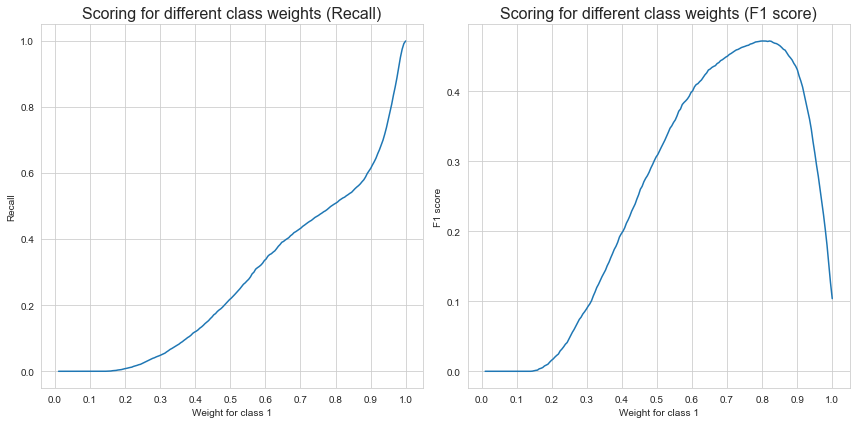

In [ ]:
d_t = DecisionTreeClassifier(class_weight="balanced")
d_t.fit(X_train, y_train)

# Calculate the train accuracy of the classifier
tr_accuracy_d_t = d_t.score(X_train, y_train)

# Calculate the accuracy of the classifier
ts_accuracy_d_t = d_t.score(X_test,y_test)

print("Train Accuracy:", f'{round(tr_accuracy_d_t, 4) * 100}%')
print("Test Accuracy:", f'{round(ts_accuracy_d_t, 4) * 100}%')
y_pred_d_t = d_t.predict(X_test)
print("Classification Report for decision tree: \n", classification_report(y_test, y_pred_d_t))

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='linear',gamma='auto',class_weight="balanced") #soft margin SVM, default C=1.0
svm.fit(X_train,y_train)
print("Test Accuracy:", svm.score(X_test,y_test))
y_pred_svm = svm.predict(X_test)
print("Classification Report for SVM: \n", classification_report(y_test, y_pred_svm))

No class_weight parameter in knn.

In [ ]:
cm_logReg = confusion_matrix(y_test,y_pred_logReg) # confusion matrix
cm_dt = confusion_matrix(y_test,y_pred_d_t) # confusion matrix
cm_svm = confusion_matrix(y_test,y_pred_svm) # confusion matrix
#cm_knn = confusion_matrix(y_test,y_pred_knn) # confusion matrix

def plot_confusion_matrix(ax, cm, title='Confusion matrix', cmap='viridis'):
    sns.heatmap(cm, annot=True, linewidths=0.8, fmt='d', cmap=cmap, ax=ax)
    ax.set_xlabel('Predicted',fontsize=16)
    ax.set_ylabel('Truth',fontsize=16)
    ax.set_title(title,fontsize=16)

fig, axs = plt.subplots(2,2, figsize=(10,4))

plot_confusion_matrix(axs[0,0], cm_logReg, title='Logistic Regression')
plot_confusion_matrix(axs[0,1], cm_dt, title='Decision Tree')
plot_confusion_matrix(axs[1,0], cm_svm, title='SVM')
#plot_confusion_matrix(axs[1,1], cm_knn, title='KNN')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import (accuracy_score,confusion_matrix, classification_report, roc_auc_score,
f1_score, recall_score, precision_score, SCORERS)
def baseline_models(data=[], verbose=False,k=10):
    #List of models to be used
    models=[DecisionTreeClassifier(class_weight="balanced"),LogisticRegression(class_weight="balanced"),
            SVC(kernel='linear',gamma='auto',class_weight="balanced"),KNeighborsClassifier(k)]
    #Create training and testing data sets depending on wheather or not they have been generated previously.
    if len(data)== 2:
        X_train, X_test, y_train, y_test = train_test_split(data[0],data[1],random_state=123)
    else:
        X_train, X_test, y_train, y_test = data[0],data[1],data[2],data[3]
    #Instantiate lists to store each of the models results
    accuracy = []
    f1 = []
    auc = []
    recall = []
    precision = []
    #Run thorugh each of the models to get their performance metrics
    for model in models:
        clf = model
        clf.fit(X_train, y_train)
        test_preds = clf.predict(X_test)
        f1.append(f1_score(y_test, test_preds))
        accuracy.append(accuracy_score(y_test, test_preds))
        auc.append(roc_auc_score(y_test, test_preds))
        recall.append(recall_score(y_test, test_preds))
        precision.append(precision_score(y_test, test_preds))
        #Print the model and its report
        if verbose:
            print('Classification Model: ',model,'\n')
            print(classification_report(y_test, test_preds),'\n')
    #store results in dataframe
    results = pd.DataFrame([f1,auc, accuracy, precision,recall],
                      index= ['f1','roc_auc','accuracy','precision','recall',],
                           columns=['DecisionTree','LogisticRegression','SVM','KNN'])
    #Change orientation of the dataframe
    return results.transpose()

In [ ]:
#smote nc with sampling strategy 1 (50%-50% after smote nc)
results1 = baseline_models(data=[X_train, X_test, y_train, y_test],k=round(np.sqrt(len(X_train))))
results1.sort_values('f1',ascending=False)

# 7 Advanced models

In [80]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

## 7.1 Random Forest


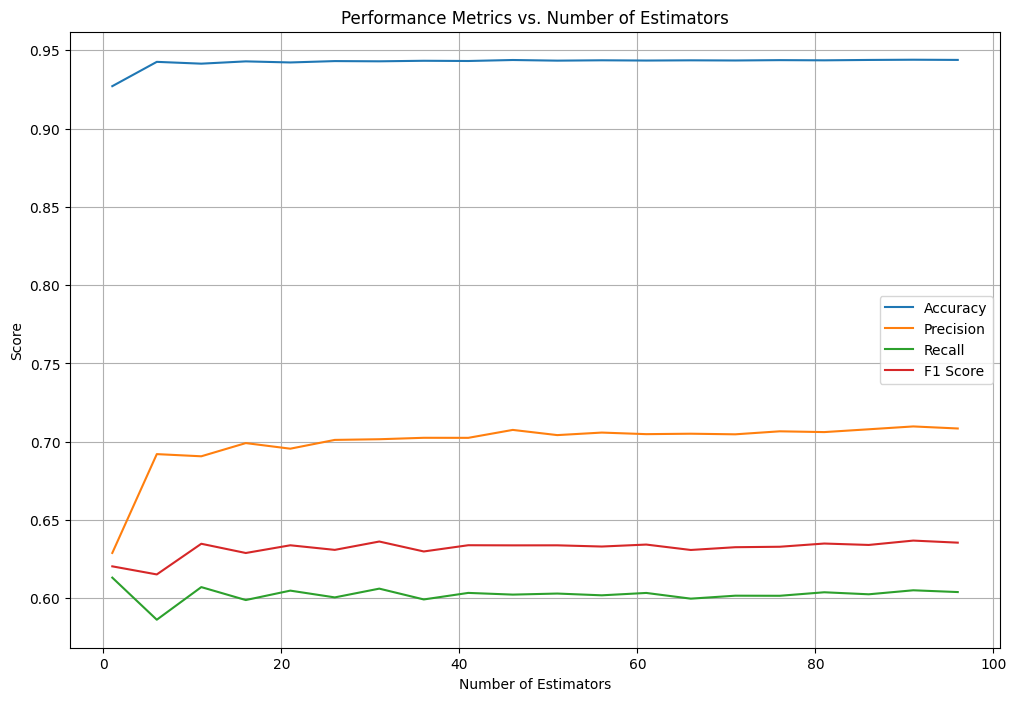

In [81]:
n_estimators_range = range(1, 101,5)

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

for n_estimators in n_estimators_range:
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

    # Train the classifier
    rf_classifier.fit(X_train, y_train)

    # predictions on testing data
    y_pred = rf_classifier.predict(X_test)

    # evaluation metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred, average='macro'))
    recall_scores.append(recall_score(y_test, y_pred, average='macro'))
    f1_scores.append(f1_score(y_test, y_pred, average='macro'))
    #roc_auc_scores.append(roc_auc_score(y_test, rf_classifier.predict_proba(X_test), multi_class='ovr'))

# Plot the performance metrics against n_estimators
plt.figure(figsize=(12, 8))

plt.plot(n_estimators_range, accuracy_scores, label='Accuracy')
plt.plot(n_estimators_range, precision_scores, label='Precision')
plt.plot(n_estimators_range, recall_scores, label='Recall')
plt.plot(n_estimators_range, f1_scores, label='F1 Score')
#plt.plot(n_estimators_range, roc_auc_scores, label='ROC AUC')

plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('Performance Metrics vs. Number of Estimators')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
from sklearn.model_selection import cross_val_score

n_estimators_range = range(1, 101,10)

# Initialize lists to store cross-validated evaluation metrics
cv_accuracy_scores = []
cv_precision_scores = []
cv_recall_scores = []
cv_f1_scores = []
#cv_roc_auc_scores = []

for n_estimators in n_estimators_range:
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

    # Perform cross-validation (5-fold CV)
    cv_accuracy = cross_val_score(rf_classifier, X, y, cv=5, scoring='accuracy')
    cv_precision = cross_val_score(rf_classifier, X, y, cv=5, scoring='precision_macro')
    cv_recall = cross_val_score(rf_classifier, X, y, cv=5, scoring='recall_macro')
    cv_f1 = cross_val_score(rf_classifier, X, y, cv=5, scoring='f1_macro')
    #cv_roc_auc = cross_val_score(rf_classifier, X, y, cv=5, scoring='roc_auc_ovr')

    # Calculate mean cross-validated scores
    cv_accuracy_scores.append(np.mean(cv_accuracy))
    cv_precision_scores.append(np.mean(cv_precision))
    cv_recall_scores.append(np.mean(cv_recall))
    cv_f1_scores.append(np.mean(cv_f1))
    #cv_roc_auc_scores.append(np.mean(cv_roc_auc))

# Plot performance metrics against n_estimators
plt.figure(figsize=(12, 8))

plt.plot(n_estimators_range, cv_accuracy_scores, label='CV Accuracy')
plt.plot(n_estimators_range, cv_precision_scores, label='CV Precision')
plt.plot(n_estimators_range, cv_recall_scores, label='CV Recall')
plt.plot(n_estimators_range, cv_f1_scores, label='CV F1 Score')
#plt.plot(n_estimators_range, cv_roc_auc_scores, label='CV ROC AUC')

plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('Cross-Validated Performance Metrics vs. Number of Estimators')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.show()

NameError: name 'y' is not defined

In [ ]:
n_estimators_range = range(1, 15,1)

cv_accuracy_scores = []
cv_precision_scores = []
cv_recall_scores = []
cv_f1_scores = []
#cv_roc_auc_scores = []

for n_estimators in n_estimators_range:
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=92)

    # Perform cross-validation (5-fold CV)
    cv_accuracy = cross_val_score(rf_classifier, X, y, cv=5, scoring='accuracy')
    cv_precision = cross_val_score(rf_classifier, X, y, cv=5, scoring='precision_macro')
    cv_recall = cross_val_score(rf_classifier, X, y, cv=5, scoring='recall_macro')
    cv_f1 = cross_val_score(rf_classifier, X, y, cv=5, scoring='f1_macro')
    #cv_roc_auc = cross_val_score(rf_classifier, X, y, cv=5, scoring='roc_auc_ovr')

    # Calculate mean cross-validated scores
    cv_accuracy_scores.append(np.mean(cv_accuracy))
    cv_precision_scores.append(np.mean(cv_precision))
    cv_recall_scores.append(np.mean(cv_recall))
    cv_f1_scores.append(np.mean(cv_f1))
    #cv_roc_auc_scores.append(np.mean(cv_roc_auc))

# Plot performance metrics against n_estimators
plt.figure(figsize=(12, 8))

plt.plot(n_estimators_range, cv_accuracy_scores, label='CV Accuracy')
plt.plot(n_estimators_range, cv_precision_scores, label='CV Precision')
plt.plot(n_estimators_range, cv_recall_scores, label='CV Recall')
plt.plot(n_estimators_range, cv_f1_scores, label='CV F1 Score')
#plt.plot(n_estimators_range, cv_roc_auc_scores, label='CV ROC AUC')

plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('Cross-Validated Performance Metrics vs. Number of Estimators')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.show()


Hence, we might choose n_estimators = 7.

## 7.2 Gradient Boosting


In [83]:
gb_clf = GradientBoostingClassifier(n_estimators=250, learning_rate=0.5, random_state=89)

# Train the classifier
gb_clf.fit(X_train, y_train)

# predictions on the training set
y_train_pred = gb_clf.predict(X_train)

# predictions on the test set
y_test_pred = gb_clf.predict(X_test)

# training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy*100:.2f}%")

# test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Training Accuracy: 95.08%
Test Accuracy: 94.85%


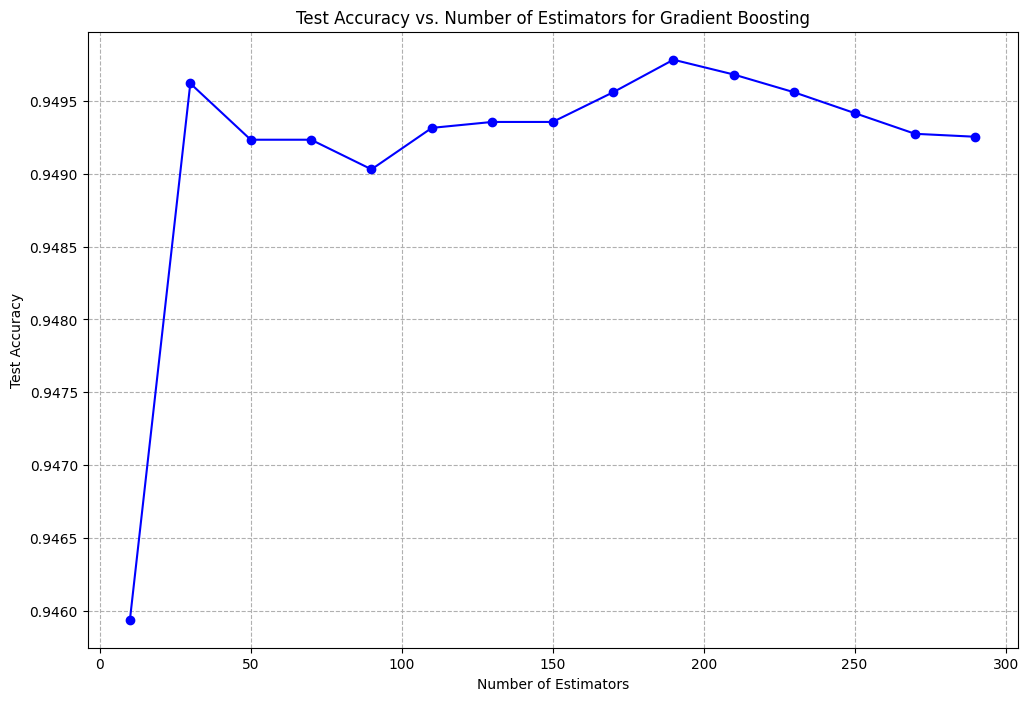

In [84]:
n_estimators_range = range(10, 310, 20)

test_accuracy_scores = []

# Iterate over n_estimators values
for n_estimators in n_estimators_range:
    gb_classifier = GradientBoostingClassifier(n_estimators=n_estimators, random_state=92)

    # model fitting
    gb_classifier.fit(X_train, y_train)

    # Predict on test data
    y_pred = gb_classifier.predict(X_test)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    test_accuracy_scores.append(test_accuracy)

# Plot the test accuracy against n_estimators
plt.figure(figsize=(12, 8))
plt.plot(n_estimators_range, test_accuracy_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Estimators')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Number of Estimators for Gradient Boosting')
plt.grid(True, which='both', linestyle='--')
plt.show()


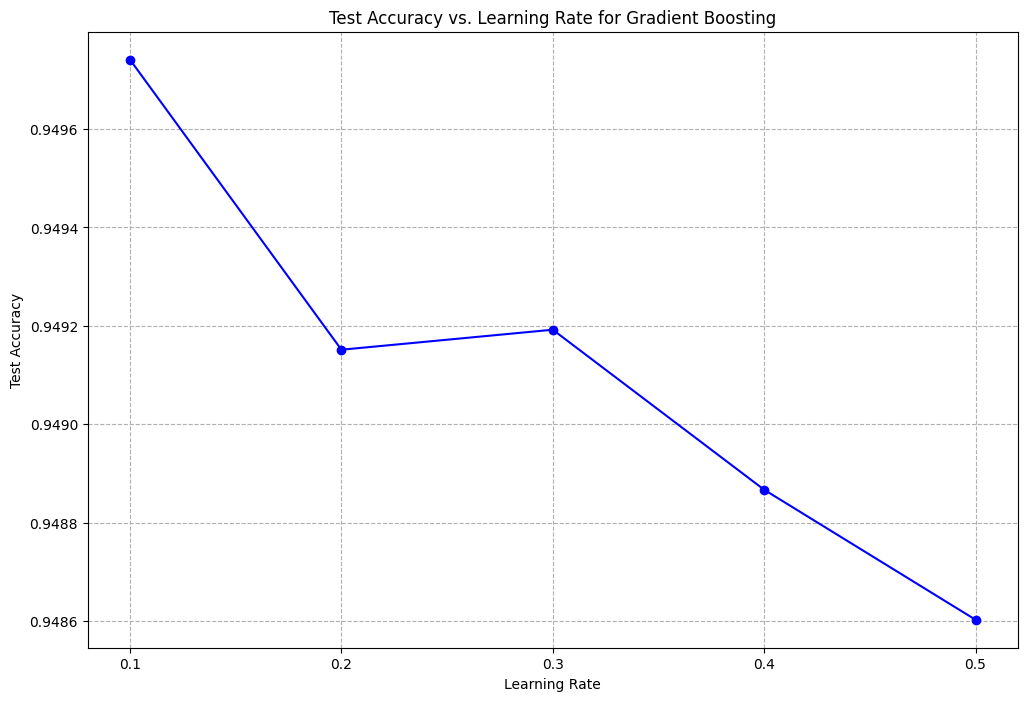

In [85]:
learning_rates = [0.1,0.2,0.3,0.4,0.5]

test_accuracy_scores = []

for lr in learning_rates:
    gb_classifier = GradientBoostingClassifier(learning_rate=lr, n_estimators=200, random_state=83)

    # Fit model on training data
    gb_classifier.fit(X_train, y_train)

    # Predict on test data
    y_pred = gb_classifier.predict(X_test)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    test_accuracy_scores.append(test_accuracy)

# Plot the test accuracy against learning rates
plt.figure(figsize=(12, 8))
plt.plot(learning_rates, test_accuracy_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Learning Rate')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Learning Rate for Gradient Boosting')

plt.xticks(learning_rates, labels=[str(lr) for lr in learning_rates])

plt.grid(True, which='both', linestyle='--')
plt.show()



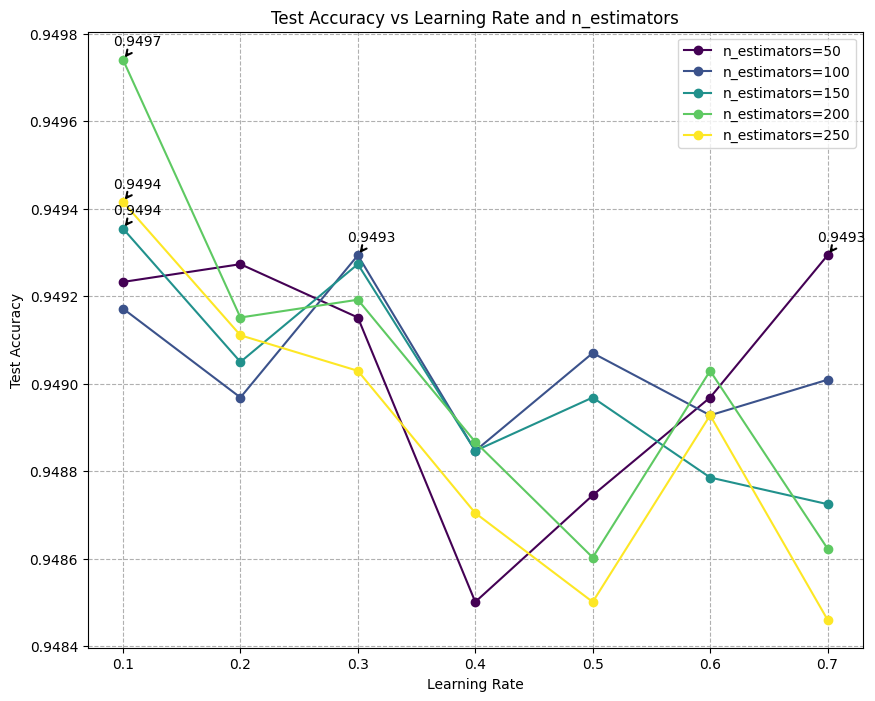

In [86]:
import itertools

# Define the range of hyperparameters
n_estimators_range = [50, 100, 150, 200, 250]
learning_rates = [0.1,0.2,0.3,0.4,0.5,0.6,0.7 ]

results = []

# Iterate over the hyperparameter combinations
for n_estimators, learning_rate in itertools.product(n_estimators_range, learning_rates):
    gb_clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=77)

    # Train the classifier
    gb_clf.fit(X_train, y_train)

    # Calculate the test accuracy
    test_accuracy = accuracy_score(y_test, gb_clf.predict(X_test))

    # Append the hyperparameters
    results.append((n_estimators, learning_rate, test_accuracy))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(n_estimators_range)))

# Plot the accuracies for each n_estimators
for (n_estimators, color) in zip(n_estimators_range, colors):
    # Filter the results for the current number of estimators
    filtered_results = [res for res in results if res[0] == n_estimators]

    # Sort the results by learning rate for plot visualization
    filtered_results.sort(key=lambda x: x[1])

    # Separate out the learning rates and corresponding accuracies
    lrates = [res[1] for res in filtered_results]
    accs = [res[2] for res in filtered_results]

    # Plot the line plot for the current number of estimators
    ax.plot(lrates, accs, color=color, marker='o', linestyle='-', label=f'n_estimators={n_estimators}')

    # Annotate the best point
    max_acc = max(accs)
    best_lr = lrates[accs.index(max_acc)]
    ax.annotate(f'{max_acc:.4f}', xy=(best_lr, max_acc), xytext=(10, 10),
                textcoords='offset points', arrowprops=dict(arrowstyle='->', lw=1.5), ha='center')

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy vs Learning Rate and n_estimators')
ax.legend()

plt.grid(True, which='both', linestyle='--')
plt.show()


In [87]:
# Compute precision, recall, and F1 score for the test set
precision = precision_score(y_test, y_test_pred, average='binary')
recall = recall_score(y_test, y_test_pred, average='binary')
f1 = f1_score(y_test, y_test_pred, average='binary')

print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")


Precision: 55.89%
Recall: 22.48%
F1 Score: 32.06%


# 8 Conclusion and Recommendations
